# CW2 - Machine/Deep learning algorithms in cryptocurrency trading

### Data set selection and definition of ML objective

**Objectives**:

1. Use machine/deep learning to predict bitcoin closing price in USD(United States Dollar). 

2. Investigate which features are the most important when it comes to making the above prediction. 

**Dataset chosen**:

[Kaggle - Top 100 Cryptocurrencies Historical Dataset](https://www.kaggle.com/datasets/kaushiksuresh147/top-10-cryptocurrencies-historical-dataset/data)

Dataset is chosen because it contains a large historical bitcoin price data from 2011-2022, moreover it contains data for other popular cryptocurrencies allowing us to investigate whether price of other cryptos effect bitcoin. The dataset contains the following columns: 

1.	**Date** :	Date of the crypto prices
2.	**Close**:	Closing prices of crypto(dollars)
3.	**Open** :	Opening price of crypto on the respective date(Dollars)
4.	**High** :	Highest price of crypto on the respective date(Dollars)
5.	**Low**	 :  Lowest price of crypto on the respective date(Dollars)
6.	**Vol**  :	Volume of crypto on the respective date(Dollars).

In [75]:
# First lets set the path for Kaggle API
import os

kaggle_dir = os.path.join(os.path.expanduser('~'), '.kaggle')
kaggle_file = os.path.join(kaggle_dir, 'kaggle.json')

# Check if the .kaggle directory exists before creating it
if not os.path.exists(kaggle_dir):
    os.system("mkdir -p " + kaggle_dir)
    print("Created directory " + kaggle_dir)
else:
    print("Directory " + kaggle_dir + " already exists")

# Check if the kaggle.json file exists in the .kaggle directory before moving it
if not os.path.exists(kaggle_file):
    os.system("mv kaggle.json " + kaggle_file)
    os.system("chmod 600 " + kaggle_file)
    print(f"Moved kaggle.json to {kaggle_file} and changed its permissions")
else:
    print("File " + kaggle_file + " already exists, changing its permissions not needed")


# Check if the zip file exists before downloading
if not os.path.exists('top-10-cryptocurrencies-historical-dataset.zip'):
    !kaggle datasets download -d kaushiksuresh147/top-10-cryptocurrencies-historical-dataset
    !unzip top-10-cryptocurrencies-historical-dataset.zip
    print("Downloaded and unzipped top-10-cryptocurrencies-historical-dataset.zip")
else:
    print("File top-10-cryptocurrencies-historical-dataset.zip already exists")


# Clear metrics files before writing new metrics
def clear_file_contents(filenames):
    for filename in filenames:
        if os.path.exists(filename):
            # Open the file in write mode with no content to clear it
            with open(filename, 'w') as file:
                pass  # Opening in 'w' mode and closing the file clears its contents

files_to_check = ["model_test_data_metrics.txt", "price_features_metrics.txt"]
clear_file_contents(files_to_check)

Directory /home/realtime/.kaggle already exists
File /home/realtime/.kaggle/kaggle.json already exists, changing its permissions not needed
File top-10-cryptocurrencies-historical-dataset.zip already exists


# Data preparation and Analysis

Here the following techniques are implemented:

1. Analyse the data in the .csv file. Usually cryptocurrency datasets are clean so we don't have to do much cleaning. 

2. Plot and visualise the price of Bitcoin and how it changed during the COVID-19 period(2020 onwards). Visualise Bitcoin along with prices of other popular cryptos(Litecoin, Ethereum and Ripple(xrp)).

3. Feature engineering, added important financial indicators : moving averages, moving average convergence divergence, relative strength index, volatility and price direction. 

4. Plot correlation heatmap, here Pearson correlation coefficient is used. This is to identify linear relationships of the feature with the target variable. 

5. Find feature importance scores using XGBoost algorithm to identify the most usefull features, especially any non-linear relationships not found in the correlation heatmap. 

In [76]:
# Loading the data into dataframes
import pandas as pd

# List of cryptocurrencies
cryptos = ['bitcoin', 'litecoin', 'ethereum', 'xrp']

# Dictionary to store the dataframes
dfs = {}

# Load each CSV file into a DataFrame and store it in the dictionary
for crypto in cryptos:
    df_name = 'raw_' + crypto + '_pd'
    dfs[df_name] = pd.read_csv(f'Top 100 Crypto Coins/{crypto}.csv')
    print(f"Top 5 rows of {df_name}:")
    print(dfs[df_name].head())
    print("\n")

    print(f"Statistics for {df_name}:")
    print(dfs[df_name].describe())
    print("\n")
    
    print(f"Missing values in {df_name}:")
    print(dfs[df_name].isnull().sum())
    print("\n")


Top 5 rows of raw_bitcoin_pd:
         Date  Open  High  Low  Close  Volume Currency
0  2010-07-18   0.0   0.1  0.1    0.1      75      USD
1  2010-07-19   0.1   0.1  0.1    0.1     574      USD
2  2010-07-20   0.1   0.1  0.1    0.1     262      USD
3  2010-07-21   0.1   0.1  0.1    0.1     575      USD
4  2010-07-22   0.1   0.1  0.1    0.1    2160      USD


Statistics for raw_bitcoin_pd:
               Open          High           Low         Close        Volume
count   4420.000000   4420.000000   4420.000000   4420.000000  4.420000e+03
mean    8302.221855   8531.971380   8043.473869   8306.969457  1.395788e+07
std    14598.398937  14992.605971  14146.499234  14599.046649  1.645973e+08
min        0.000000      0.100000      0.000000      0.100000  0.000000e+00
25%      122.500000    129.975000    118.300000    122.800000  3.013600e+04
50%      683.600000    706.500000    657.550000    685.000000  6.762050e+04
75%     8877.250000   9122.700000   8666.900000   8886.075000  1.769402e+05

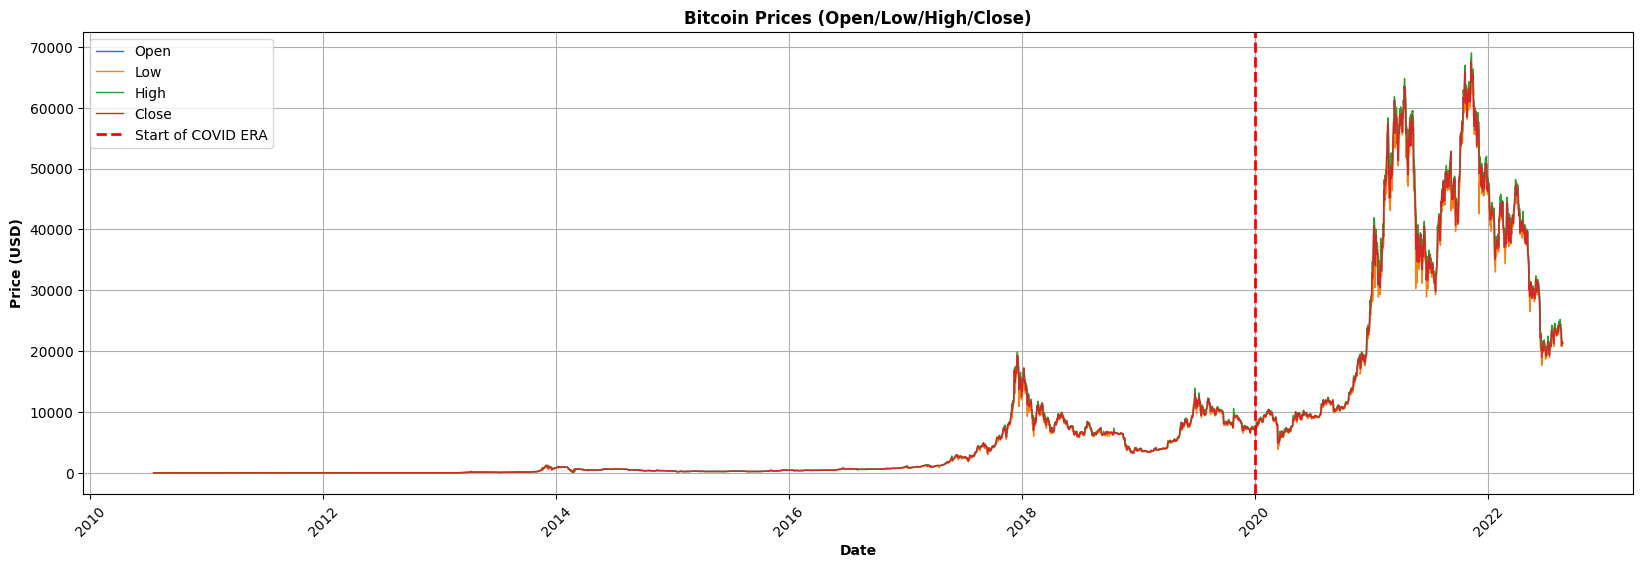

In [77]:
import matplotlib.pyplot as plt

# Assuming dfs['raw_bitcoin_pd'] is your DataFrame
df_bitcoin_1 = dfs['raw_bitcoin_pd'].copy()

# Convert 'Date' column to datetime if it's not already
df_bitcoin_1['Date'] = pd.to_datetime(df_bitcoin_1['Date'])

# Plotting
plt.figure(figsize=(20, 6))

# Plot Open, Low, High, Close prices
plt.plot(df_bitcoin_1['Date'], df_bitcoin_1['Open'], label='Open', linewidth=1)
plt.plot(df_bitcoin_1['Date'], df_bitcoin_1['Low'], label='Low', linewidth=1)
plt.plot(df_bitcoin_1['Date'], df_bitcoin_1['High'], label='High', linewidth=1)
plt.plot(df_bitcoin_1['Date'], df_bitcoin_1['Close'], label='Close', linewidth=1)

# Highlighting the "COVID ERA" starting from 2020
plt.axvline(pd.Timestamp('2020-01-01'), color='r', linestyle='--', linewidth=2, label='Start of COVID ERA')

# Adding legend
plt.legend()

# Adding grid
plt.grid(True)

# Set the title and axis labels
plt.title('Bitcoin Prices (Open/Low/High/Close)', fontweight='bold')
plt.xlabel('Date', fontweight='bold')
plt.ylabel('Price (USD)', fontweight='bold')

# Rotate date labels for better readability
plt.xticks(rotation=45)

plt.show()

/usr/lib/python3/dist-packages/pandas/core/indexing.py:1835: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
/usr/lib/python3/dist-packages/pandas/core/indexing.py:1835: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
/usr/lib/python3/dist-packages/pandas/core/indexing.py:1835: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

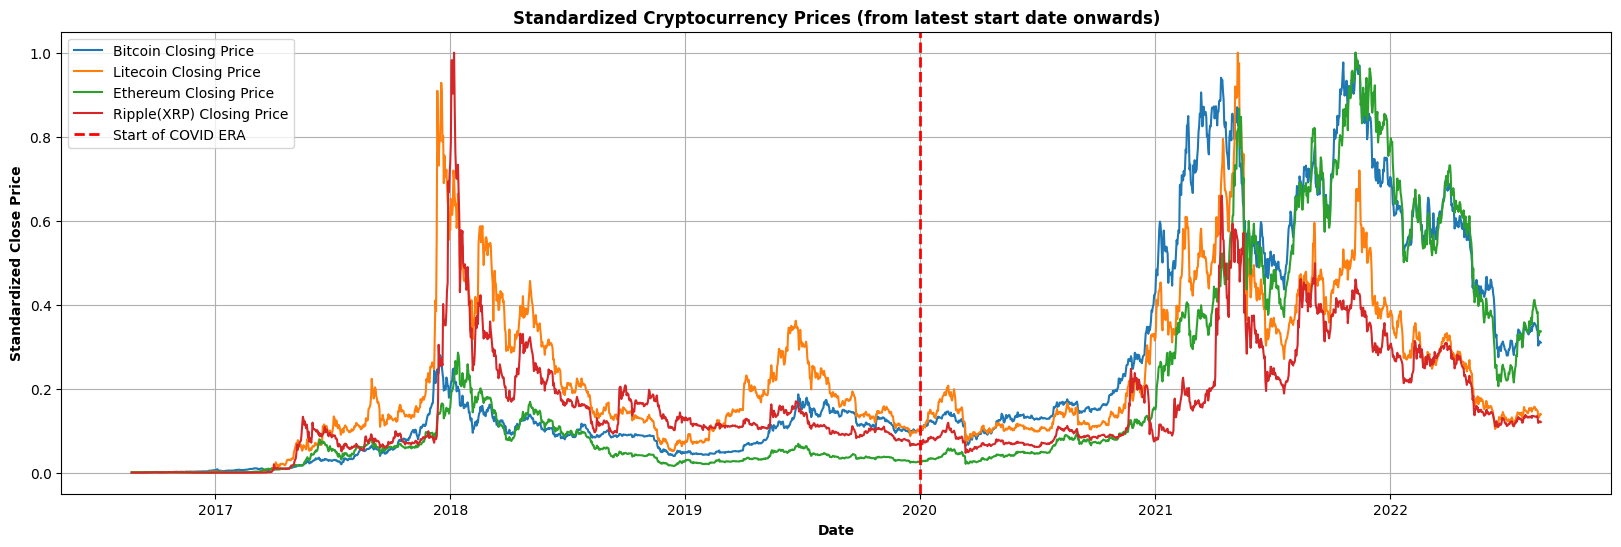

In [78]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

dfs_copied = dfs.copy()
scaler = MinMaxScaler()

# Convert 'Date' to datetime and set it as index
for df_name, df in dfs_copied.items():
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)

# Find the latest starting date among all the cryptocurrencies
latest_start_date = max(df.index.min() for df in dfs_copied.values())

label_names = {}
label_names['raw_bitcoin_pd']  = 'Bitcoin Closing Price'
label_names['raw_litecoin_pd'] = 'Litecoin Closing Price'
label_names['raw_ethereum_pd'] = 'Ethereum Closing Price'
label_names['raw_xrp_pd']      = 'Ripple(XRP) Closing Price'   

# Plot each cryptocurrency's closing price
plt.figure(figsize=(20, 6))
for df_name, df in dfs_copied.items():
    df = df.loc[df.index >= latest_start_date]  # Filter data from the latest start date onwards
    df.loc[:, 'Close'] = scaler.fit_transform(df[['Close']])  # Standardize 'Close' price
    plt.plot(df.index, df['Close'], label=label_names[df_name])

# Adding a vertical line to mark the start of the "COVID ERA"
plt.axvline(pd.Timestamp('2020-01-01'), color='r', linestyle='--', linewidth=2, label='Start of COVID ERA')

plt.title('Standardized Cryptocurrency Prices (from latest start date onwards)', fontweight='bold')
plt.xlabel('Date', fontweight='bold')
plt.ylabel('Standardized Close Price', fontweight='bold')
plt.legend()
plt.grid(True)
plt.show()

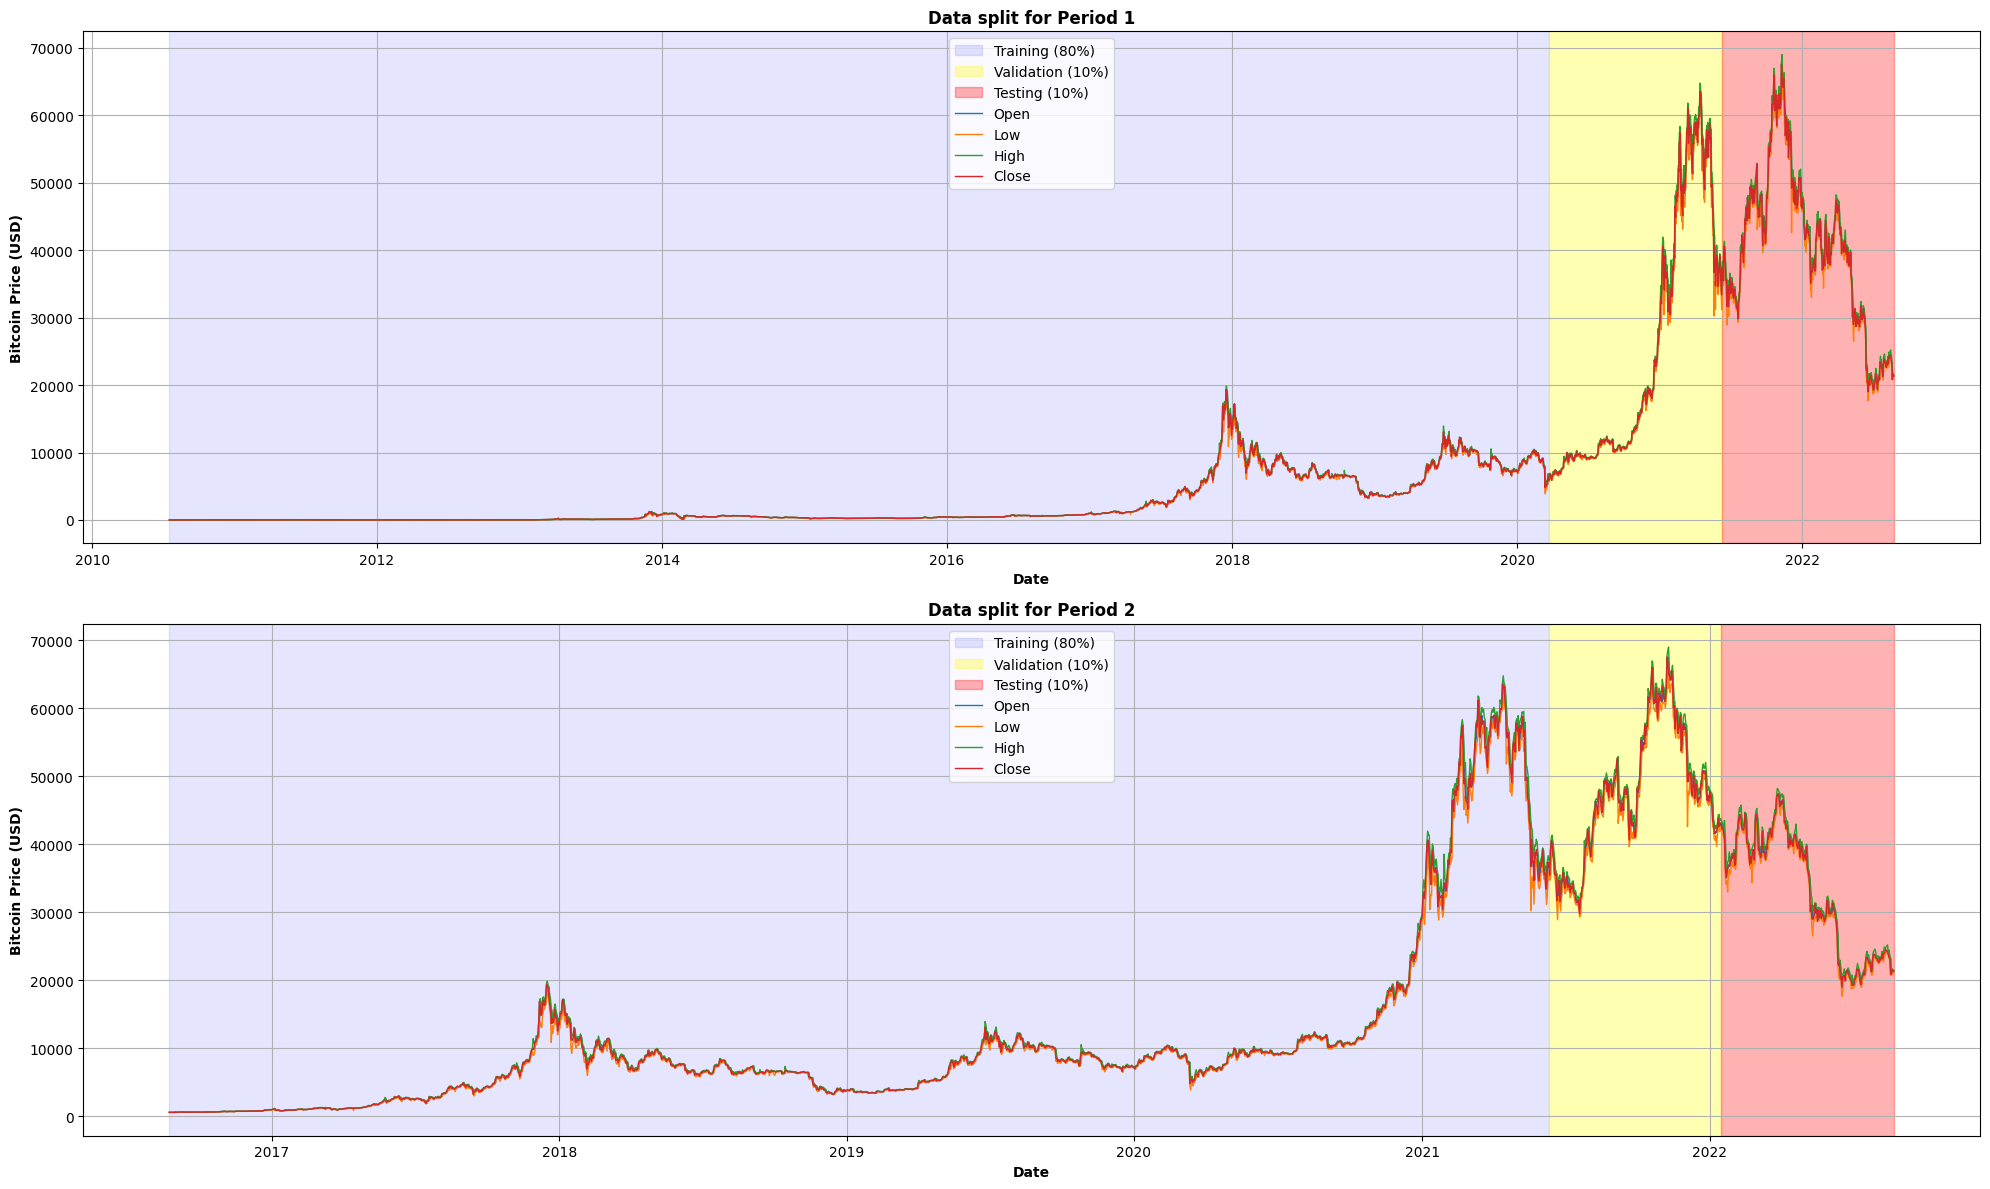

In [79]:
# Function to highlight splits
def highlight_splits(ax, df, title):
    total_rows = len(df)
    train_end = int(total_rows * 0.8)
    val_end = train_end + int(total_rows * 0.1)

    # Highlight training, validation, testing regions
    ax.axvspan(df['Date'].iloc[0], df['Date'].iloc[train_end], color='blue', alpha=0.1, label='Training (80%)')
    ax.axvspan(df['Date'].iloc[train_end], df['Date'].iloc[val_end], color='yellow', alpha=0.3, label='Validation (10%)')
    ax.axvspan(df['Date'].iloc[val_end], df['Date'].iloc[-1], color='red', alpha=0.3, label='Testing (10%)')

    # Plot Open, Low, High, Close prices
    ax.plot(df['Date'], df['Open'], label='Open', linewidth=1)
    ax.plot(df['Date'], df['Low'], label='Low', linewidth=1)
    ax.plot(df['Date'], df['High'], label='High', linewidth=1)
    ax.plot(df['Date'], df['Close'], label='Close', linewidth=1)

    ax.set_title(title, fontweight='bold')
    ax.set_xlabel('Date', fontweight='bold')
    ax.set_ylabel('Bitcoin Price (USD)', fontweight='bold')
    ax.legend()
    ax.grid(True)

# Prepare subplot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 12))

# Plot for Period 1 (Entire Dataset)
highlight_splits(ax1, df_bitcoin_1, "Data split for Period 1")

# Prepare data for Period 2 (Last 2191 rows)
df_bitcoin_2 = df_bitcoin_1.iloc[-2191:].reset_index(drop=True)

# Plot for Period 2
highlight_splits(ax2, df_bitcoin_2, "Data split for Period 2")

plt.tight_layout()
plt.show()

### Feature engineering:

Here we added important financial indicators : moving averages, moving average convergence divergence, relative strength index, volatility and price direction. 

            Open  High  Low  Close  Volume Currency  SMA_50  SMA_200  \
Date                                                                   
2011-02-02   0.7   0.8  0.7    0.7    5627      USD   0.336   0.1945   
2011-02-03   0.7   0.8  0.7    0.7    8525      USD   0.346   0.1975   
2011-02-04   0.7   0.9  0.7    0.8   42222      USD   0.356   0.2010   
2011-02-05   0.8   0.9  0.8    0.9   15787      USD   0.370   0.2050   
2011-02-06   0.9   0.9  0.8    0.9    8744      USD   0.384   0.2090   
2011-02-07   0.9   0.9  0.8    0.9    2264      USD   0.398   0.2130   

              EMA_50   EMA_200      MACD  Signal_Line    RSI  Daily_Return  \
Date                                                                         
2011-02-02  0.362980  0.231407  0.074939     0.045136  100.0      0.000000   
2011-02-03  0.376197  0.236069  0.085494     0.053207  100.0      0.000000   
2011-02-04  0.392816  0.241681  0.100766     0.062719  100.0      0.142857   
2011-02-05  0.412706  0.248231  0

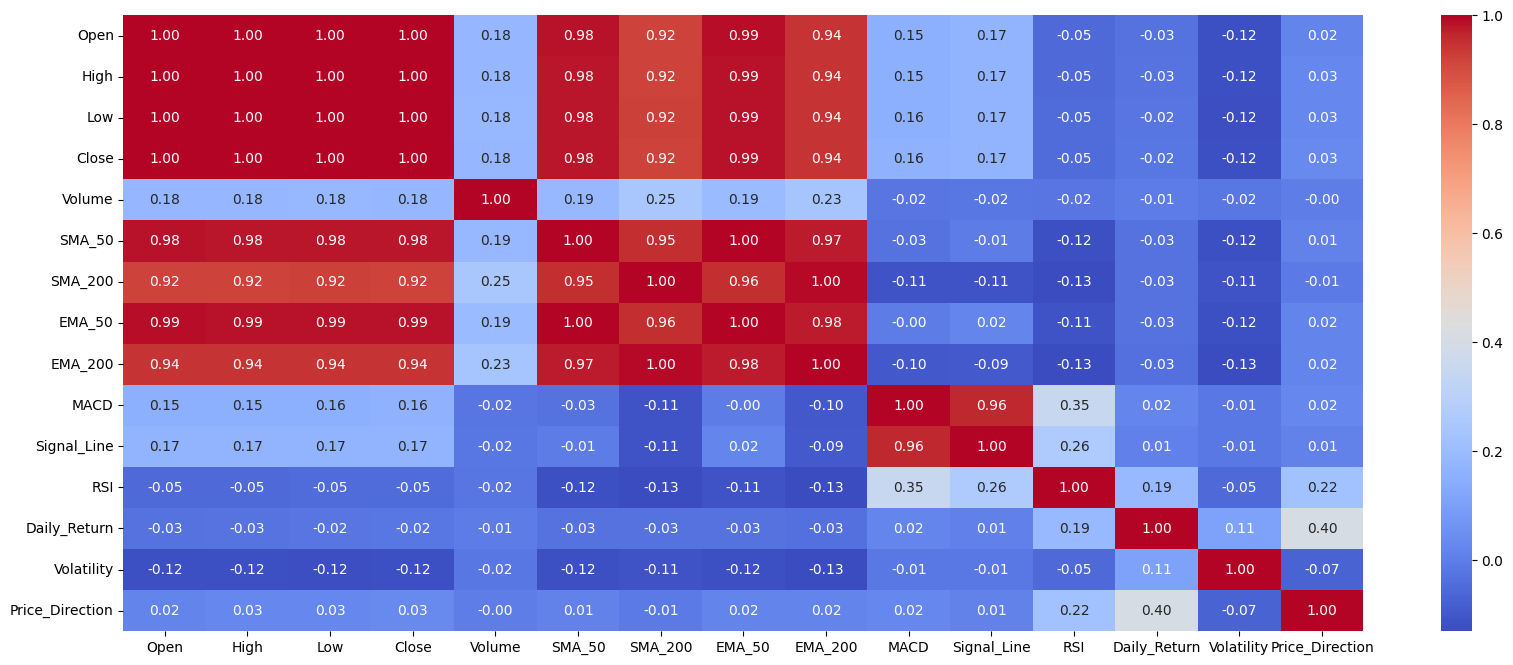

                    Close
Close            1.000000
High             0.999556
Low              0.999468
Open             0.998996
EMA_50           0.985747
SMA_50           0.981267
EMA_200          0.943088
SMA_200          0.919309
Volume           0.182242
Signal_Line      0.169732
MACD             0.156964
Price_Direction  0.033989
Daily_Return    -0.019557
RSI             -0.048863
Volatility      -0.120992


In [80]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

# We need to add more features to the model to improve its accuracy
# Assuming dfs['raw_bitcoin_pd'] is your DataFrame for Bitcoin
df_bitcoin_2 = dfs['raw_bitcoin_pd'].copy()

# Calculate Moving Averages
df_bitcoin_2['SMA_50']  = df_bitcoin_2['Close'].rolling(window=50).mean()
df_bitcoin_2['SMA_200'] = df_bitcoin_2['Close'].rolling(window=200).mean()

# Calculate Exponential Moving Averages
df_bitcoin_2['EMA_50'] = df_bitcoin_2['Close'].ewm(span=50, adjust=False).mean()
df_bitcoin_2['EMA_200'] = df_bitcoin_2['Close'].ewm(span=200, adjust=False).mean()

# Calculate MACD
# MACD Line = 12-day EMA - 26-day EMA
# Signal Line = 9-day EMA of MACD Line
# MACD Histogram = MACD Line - Signal Line
EMA_12 = df_bitcoin_2['Close'].ewm(span=12, adjust=False).mean()
EMA_26 = df_bitcoin_2['Close'].ewm(span=26, adjust=False).mean()
df_bitcoin_2['MACD'] = EMA_12 - EMA_26
df_bitcoin_2['Signal_Line']    = df_bitcoin_2['MACD'].ewm(span=9, adjust=False).mean()

# Calculate RSI
delta = df_bitcoin_2['Close'].diff(1)
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
RS = gain / loss
df_bitcoin_2['RSI'] = 100 - (100 / (1 + RS))

# Calculate Volatility (as the standard deviation of daily returns)
df_bitcoin_2['Daily_Return'] = df_bitcoin_2['Close'].pct_change()
df_bitcoin_2['Volatility']   = df_bitcoin_2['Close'].pct_change().rolling(window=50).std() * np.sqrt(50)

# If today's close is higher than yesterday's close, price direction is 1 (up), otherwise 0 (down or unchanged)
df_bitcoin_2['Price_Direction'] = (df_bitcoin_2['Close'] > df_bitcoin_2['Close'].shift(1)).astype(int)

# Display the head of the DataFrame to verify the new columns
print(df_bitcoin_2.iloc[199:205])


# Calculate the correlation matrix
correlation_matrix = df_bitcoin_2.corr()

# Focus on the 'High' and 'Low' columns
correlation_with_target = correlation_matrix[['Close']].sort_values(by='Close', ascending=False)
plt.figure(figsize=(20, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.show()
# Print the correlation values
print(correlation_with_target)

In [81]:
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import TimeSeriesSplit, cross_val_score

def feature_importance_verifier(df, feature):
    # Ensure specified columns exist in the DataFrame, then drop them if they do
    y = df[feature]  # Target variable
    columns_to_drop = ['Date', 'Currency', 'Close', feature]
    X = df.drop(columns=[col for col in columns_to_drop if col in df.columns], axis=1)

    # Initialize the random forest
    xgb = XGBRegressor(n_estimators=100, random_state=42)

    # Initialize TimeSeriesSplit
    tscv = TimeSeriesSplit(n_splits=5)

    # Perform cross-validation
    cv_scores = cross_val_score(xgb, X, y, cv=tscv, scoring='neg_mean_squared_error')

    # Print cross-validation scores
    print(f"Cross-validation scores (MSE): {-cv_scores}")
    print(f"Mean cross-validation score (MSE): {-cv_scores.mean()}")

    # Fit the model to the data
    xgb.fit(X, y)

    # Extract feature importance
    importances = xgb.feature_importances_
    indices = np.argsort(importances)[::-1]

    # Print the feature ranking
    print(f"Feature ranking for {feature}:")
    for f in range(X.shape[1]):
        print(f"{f + 1}. feature {X.columns[indices[f]]} ({importances[indices[f]]})")
  

In [82]:
# We know our data has NaN values, so we need to clean it before training the models
initial_row_count = len(df_bitcoin_2)
df_bitcoin_2_clean = df_bitcoin_2.dropna()
rows_removed = initial_row_count - len(df_bitcoin_2_clean)
feature_importance_verifier(df_bitcoin_2_clean.copy(), 'Close')
print(f"Number of rows removed: {rows_removed}")

Cross-validation scores (MSE): [1.93950799e+05 1.50460713e+02 3.58391791e+07 7.59625990e+04
 6.91743586e+08]
Mean cross-validation score (MSE): 145570565.78002688
Feature ranking for Close:
1. feature Low (0.7557322382926941)
2. feature High (0.2399614006280899)
3. feature Open (0.0038125766441226006)
4. feature Daily_Return (0.0001877458271337673)
5. feature SMA_50 (8.049754978856072e-05)
6. feature RSI (3.808031033258885e-05)
7. feature EMA_50 (3.686710988404229e-05)
8. feature Volatility (3.4820484870579094e-05)
9. feature SMA_200 (3.2147068850463256e-05)
10. feature MACD (2.371896516706329e-05)
11. feature EMA_200 (2.3634534954908304e-05)
12. feature Volume (1.992719444388058e-05)
13. feature Signal_Line (1.6315765606123023e-05)
14. feature Price_Direction (0.0)
Number of rows removed: 203


# Model Selection and training / Results and analysis

1. We build a basic model using grated recurrent units(GRU), with the hyperparameters obtained using tuning. 

2. We build a long short term memory model(LSTM), to improve upon the previous one. 

3. We also attempt to improve upon the previous GRU model by using bidirectional GRU model.

4. Features like Open, Low and High are higly correlated to our prediction target Close. We compare the RMSE/MAE of our model's predicted closing price vs Open/Low/High to see how much better our model is comapared to the features(Open/Low/High).

### Hyperparameter tuning

Hyperparameter tuning for the models was done using a seperate python(.py) file, the code below is a sample of the hyperparameter tuning approach for the models. 

In [83]:
import tensorflow as tf
from tensorflow.keras.layers import GRU, Dropout, Dense
from tensorflow.keras.models import Sequential
from keras_tuner import HyperModel
from keras_tuner.tuners import Hyperband
import json

class GRUHyperModel(HyperModel):
    def __init__(self, input_shape):
        self.input_shape = input_shape

    def build(self, hp):
        model = Sequential()
        model.add(GRU(units=hp.Int('units', min_value=32, max_value=512, step=32),
                      return_sequences=True,
                      input_shape=self.input_shape))
        model.add(Dropout(rate=hp.Float('dropout_1', min_value=0.0, max_value=0.5, step=0.1)))
        model.add(GRU(units=hp.Int('units', min_value=32, max_value=512, step=32)))
        model.add(Dropout(rate=hp.Float('dropout_2', min_value=0.0, max_value=0.5, step=0.1)))
        model.add(Dense(1))
        
        model.compile(optimizer='adam', loss='mean_squared_error')
        return model
    
def find_and_save_hyperparameter(df, features, target, train_percent, val_percent):
    # Prepare the data
    scaler_X = StandardScaler()
    scaler_y = StandardScaler()

    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)
    
    X = df[features]
    y = df[[target]]  # Keeping it as DataFrame
    
    # Scale features and target
    X_scaled = scaler_X.fit_transform(X)
    y_scaled = scaler_y.fit_transform(y)
    
    # Reshape for LSTM [samples, time steps, features]
    X_scaled = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))
    
    # Calculate the number of rows for training and validation
    total_rows = len(df)
    train_end = int(total_rows * train_percent)
    val_end = train_end + int(total_rows * val_percent)
    
    # Split data
    X_train_scaled = X_scaled[:train_end]
    y_train_scaled = y_scaled[:train_end]
    X_val_scaled = X_scaled[train_end:val_end]
    y_val_scaled = y_scaled[train_end:val_end]

    input_shape = (X_train_scaled.shape[1], X_train_scaled.shape[2])

    tuner = Hyperband(
        GRUHyperModel(input_shape),
        objective='val_loss',
        max_epochs=20,
        directory='my_dir',
        project_name='gru_tuning'
    )

    tuner.search(X_train_scaled, y_train_scaled, epochs=10, validation_data=(X_val_scaled, y_val_scaled))

    # Save the tuning results to a file
    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
    model_metrics = {
        'units': best_hps.get('units'),
        'dropout_1': best_hps.get('dropout_1'),
        'dropout_2': best_hps.get('dropout_2')
    }

    with open('model_hyperparameter_tuning.txt', 'w') as f:
        json.dump(model_metrics, f)
        

In [84]:
# We define a class here that will be reused for training the models and plotting the prediction results ... 

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.dates as mdates
import re

from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import EarlyStopping
from collections import defaultdict
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, GRU, Dropout, Dense
from tensorflow.keras.layers import LSTM



class ModelTrainer:

    def __init__(self) -> None:
        self.train_percent        = None
        self.val_percent          = None
        self.features             = None
        self.target               = None
        self.models               = None
        self.df                   = None
        self.x_train_scaled_shape = None

        self.comparision_metrics = defaultdict(list)
        self.model_metrics       = defaultdict(list)

    def set_train_val_test_split(self, train_percent, val_percent):
        self.train_percent= train_percent
        self.val_percent = val_percent

    def set_features_and_target(self, features, target):
        self.features = features
        self.target   = target


    def set_models(self, models):
        self.models = models

    def set_dataframe(self, df):
        self.df =  df

    def get_x_train_shape(self):
        scaler_X = StandardScaler()
        if self.df.index.name != 'Date':
            self.df['Date'] = pd.to_datetime(self.df['Date'])
            self.df.set_index('Date', inplace=True)
        
        X = self.df[self.features]
        total_rows = len(self.df)
        train_end = int(total_rows *             self.train_percent)
        val_end   = train_end + int(total_rows * self.val_percent)
        X_scaled = scaler_X.fit_transform(X)
        X_scaled = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))
        X_train_scaled = X_scaled[:train_end]

        return X_train_scaled.shape

    def compute_feature_metrics_comparision(self, val_end):
        test_y = self.df[self.target][val_end:].values  # Assuming target is defined and df is your DataFrame
        price_features = ['Open', 'Low', 'High']  # Extract price features for comparison

        for feature in price_features:
            feature_raw = self.df[feature][val_end:].values
            rmse = np.sqrt(mean_squared_error(test_y, feature_raw))
            mae = mean_absolute_error(test_y, feature_raw)
            mape = np.mean(np.abs((test_y - feature_raw) / test_y)) * 100
            
            # Handling cases where test_y or feature_raw are zero to avoid division by zero error
            nonzero_mask = (test_y + feature_raw) != 0
            smape = 100 * np.mean(2 * np.abs(feature_raw[nonzero_mask] - test_y[nonzero_mask]) / (np.abs(test_y[nonzero_mask]) + np.abs(feature_raw[nonzero_mask])))
            
            self.comparision_metrics[feature].append(rmse)
            self.comparision_metrics[feature].append(mae)
            self.comparision_metrics[feature].append(mape)
            self.comparision_metrics[feature].append(smape)

    def plot_comparision_metrics(self, actual_close, predicted_close, title):
        if actual_close.ndim == 2 :
            actual_close = np.squeeze(actual_close)
        if predicted_close.ndim == 2:
            predicted_close = np.squeeze(predicted_close)

        rmse  = np.sqrt(mean_squared_error(actual_close, predicted_close))
        mae   = mean_absolute_error(actual_close, predicted_close)
        mape  = np.mean(np.abs((actual_close - predicted_close) / actual_close)) * 100
        smape = 100 * np.mean(2 * np.abs(predicted_close - actual_close) / (np.abs(actual_close) + np.abs(predicted_close)))

        # Search for exact model names in the title, case insensitive
        key = None
        for model in ["BiGRU", "GRU", "LSTM"]:  # Order matters here
            print(f"Finding model {model} in {title}")
            # Use word boundaries to ensure full words are matched
            if re.search(r'\b' + re.escape(model) + r'\b', title, re.IGNORECASE):
                key = model
                break
        
        # Save models RMSE and MAE
        self.model_metrics[key].append(rmse)
        self.model_metrics[key].append(mae)

        # Save metrics for target 
        self.comparision_metrics['Predicted Close'] = []
        self.comparision_metrics['Predicted Close'].append(rmse)
        self.comparision_metrics['Predicted Close'].append(mae)
        self.comparision_metrics['Predicted Close'].append(mape)
        self.comparision_metrics['Predicted Close'].append(smape)

        # Extracting Values
        rmse_values  = [self.comparision_metrics[key][0] for key in self.comparision_metrics]
        mae_values   = [self.comparision_metrics[key][1] for key in self.comparision_metrics]
        mape_values  = [self.comparision_metrics[key][2] for key in self.comparision_metrics]
        smape_values = [self.comparision_metrics[key][3] for key in self.comparision_metrics]

        labels = list(self.comparision_metrics.keys())
        x      = np.arange(len(labels))  # the label locations
        width  = 0.35  # the width of the bars

        fig, axs = plt.subplots(1, 2, figsize=(14, 6))

        print(self.comparision_metrics)

        # RMSE and MAE
        axs[0].bar(x - width/2, rmse_values, width, label='RMSE')
        axs[0].bar(x + width/2, mae_values, width, label='MAE')
        axs[0].set_xticks(x)
        axs[0].set_xticklabels(labels)
        axs[0].title.set_text(title)
        axs[0].legend()
        axs[0].set_ylabel('Value')
        axs[0].grid(True)

        # MAPE and sMAPE
        axs[1].bar(x - width/2, mape_values, width, label='MAPE')
        axs[1].bar(x + width/2, smape_values, width, label='sMAPE')
        axs[1].set_title('MAPE and sMAPE')
        axs[1].set_xticks(x)
        axs[1].set_xticklabels(labels)
        axs[1].legend()
        axs[1].set_ylabel('Value(%)')
        axs[1].grid(True)
        
        plt.tight_layout()
        plt.show()

    def plot_test_predictions(self, model, X_test_scaled, y_test_scaled, dates_test, scaler_X, scaler_y, title):
        """
        Plots actual test dataset vs predicted results.
        """
        # Generate predictions
        predictions_scaled = model.predict(X_test_scaled)
        predictions        = scaler_y.inverse_transform(predictions_scaled)
        actual             = scaler_y.inverse_transform(y_test_scaled)
        X_test_scaled      = X_test_scaled.reshape(X_test_scaled.shape[0], X_test_scaled.shape[2])
        features           = scaler_X.inverse_transform(X_test_scaled)

        # Plot the RMSE, MAE, MAPE, and sMAPE------------------------------
        self.plot_comparision_metrics(actual, predictions, title)
        #-----------------------------------------------------------------

        plt.figure(figsize=(18, 6))  # Adjust the figure size to better accommodate side-by-side subplots

        # Subplot 1: Actual vs. Predicted Close Prices (Left)
        plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
        plt.plot(dates_test, actual, label='Close (Actual)', color='#1f77b4', linewidth=2)
        plt.plot(dates_test, predictions, label='Close (Predicted)', color='#ff7f0e', linestyle='--', linewidth=2)
        plt.title(title)
        plt.xlabel('Date')
        plt.ylabel('Price (USD)')
        plt.legend()
        plt.xticks(rotation=45)
        plt.grid(True)
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
        plt.gca().xaxis.set_major_locator(mdates.MonthLocator())

        # Subplot 2: Actual Close vs. Open, Low, High Prices (Right)
        plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
        plt.plot(dates_test, actual, label='Close (Actual)', color='#1f77b4', linewidth=2)
        plt.plot(dates_test, features[:, 2], label='Open', color='#9467bd', linestyle='-', linewidth=2)
        plt.plot(dates_test, features[:, 0], label='Low', color='#2ca02c', linestyle=':', linewidth=2)
        plt.plot(dates_test, features[:, 1], label='High', color='#d62728', linestyle='-.', linewidth=2)
        plt.title('Close Price: Actual vs Open, Low, High')
        plt.xlabel('Date')
        plt.ylabel('Price (USD)')
        plt.legend()
        plt.xticks(rotation=45)
        plt.grid(True)
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
        plt.gca().xaxis.set_major_locator(mdates.MonthLocator())

        plt.tight_layout()
        plt.show()


    def plot_model_metrics(self):
        # Extract model names and corresponding RMSE and MAE values
        models = list(self.model_metrics.keys())
        rmse_values = [self.model_metrics[model][0] for model in models]
        mae_values  = [self.model_metrics[model][1] for model in models]

        # Setting the positions and width for the bars
        x = range(len(models))  # Model positions on the x-axis
        width = 0.35  # Width of the bars

        # Creating the bar chart
        fig, ax = plt.subplots()
        rmse_bars = ax.bar(x, rmse_values, width, label='RMSE')
        mae_bars = ax.bar([p + width for p in x], mae_values, width, label='MAE')

        # Adding some text for labels, title, and custom x-axis tick labels, etc.
        ax.set_xlabel('Models')
        ax.set_ylabel('Values')
        ax.set_title('RMSE and MAE by Model')
        ax.set_xticks([p + width / 2 for p in x])
        ax.set_xticklabels(models)
        ax.legend()

        # Adding value labels on top of each bar
        for bars in [rmse_bars, mae_bars]:  # Loop over both sets of bars
            for bar in bars:
                height = bar.get_height()
                ax.annotate('{}'.format(round(height, 2)),
                            xy=(bar.get_x() + bar.get_width() / 2, height),
                            xytext=(0, 3),  # 3 points vertical offset
                            textcoords="offset points",
                            ha='center', va='bottom')

        # Show the plot
        plt.show()

        
    def run(self):
        # Prepare the data
        scaler_X = StandardScaler()
        scaler_y = StandardScaler()

        if self.df.index.name != 'Date':
            self.df['Date'] = pd.to_datetime(self.df['Date'])
            self.df.set_index('Date', inplace=True)
        
        X = self.df[self.features]
        y = self.df[[self.target]]  # Keeping it as DataFrame

        # Calculate the number of rows for training and validation
        total_rows = len(self.df)
        train_end = int(total_rows *             self.train_percent)
        val_end   = train_end + int(total_rows * self.val_percent)

        # Compute and save feature comparision metrics--------------
        self.compute_feature_metrics_comparision(val_end)
        #----------------------------------------------------------

        # Scale features and target
        X_scaled = scaler_X.fit_transform(X)
        y_scaled = scaler_y.fit_transform(y)
        
        # Reshape for LSTM [samples, time steps, features]
        X_scaled = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))
        
        # Split data
        X_train_scaled = X_scaled[:train_end]
        y_train_scaled = y_scaled[:train_end]
        X_val_scaled = X_scaled[train_end:val_end]
        y_val_scaled = y_scaled[train_end:val_end]

        #-------------------Save the trained shape ----------
        self.x_train_scaled_shape = X_train_scaled.shape
        #----------------------------------------------------

        X_test = X_scaled[val_end:]
        y_test = y_scaled[val_end:]
        dates_test = self.df.index[val_end:]  # Extract test dates
        
        early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
        titles = ['Bitcoin close price prediction GRU', 'Bitcoin close price prediction LSTM', 'Bitcoin close price prediction BiGRU']
        for i, model in enumerate(self.models, start=1):  # start=1 begins counting from 1
            model.compile(optimizer='adam', loss='mean_squared_error') # compile the models first !
            history = model.fit(X_train_scaled, 
                                y_train_scaled, 
                                epochs=50, 
                                batch_size=32, 
                                validation_data=(X_val_scaled, y_val_scaled), 
                                verbose=0, 
                                callbacks=[early_stopping])
            self.plot_test_predictions(model, X_test, y_test, dates_test, scaler_X, scaler_y, titles[i-1])



### Building models:

1. We choose the six most important features 'Low', 'High', 'Open', 'Daily_Return', 'RSI', 'SMA_50'.

2. We build the three models GRU, LSTM and BiGRU. 

3. A 80/10/10 training, validation and test split was used. A validation split is used to train the neural network so they don't learn the test data. The test split is then used to find the metrics RMSE, MAE, MAPE and sMAPE. 

14/14 [==============================] - 0s 3ms/step
Finding model BiGRU in Bitcoin close price prediction GRU
Finding model GRU in Bitcoin close price prediction GRU
defaultdict(<class 'list'>, {'Open': [1439.6225984709913, 1033.8569739952718, 2.5959391853058618, 2.5864477561559465], 'Low': [1443.698100934896, 1050.4290780141844, 2.599630026094542, 2.6622370378728224], 'High': [1393.7700289987672, 993.2243498817968, 2.5673088590443736, 2.5050443912615736], 'Predicted Close': [1629.7235609008712, 1325.5081551049045, 3.5180362645696426, 3.4299066705471115]})


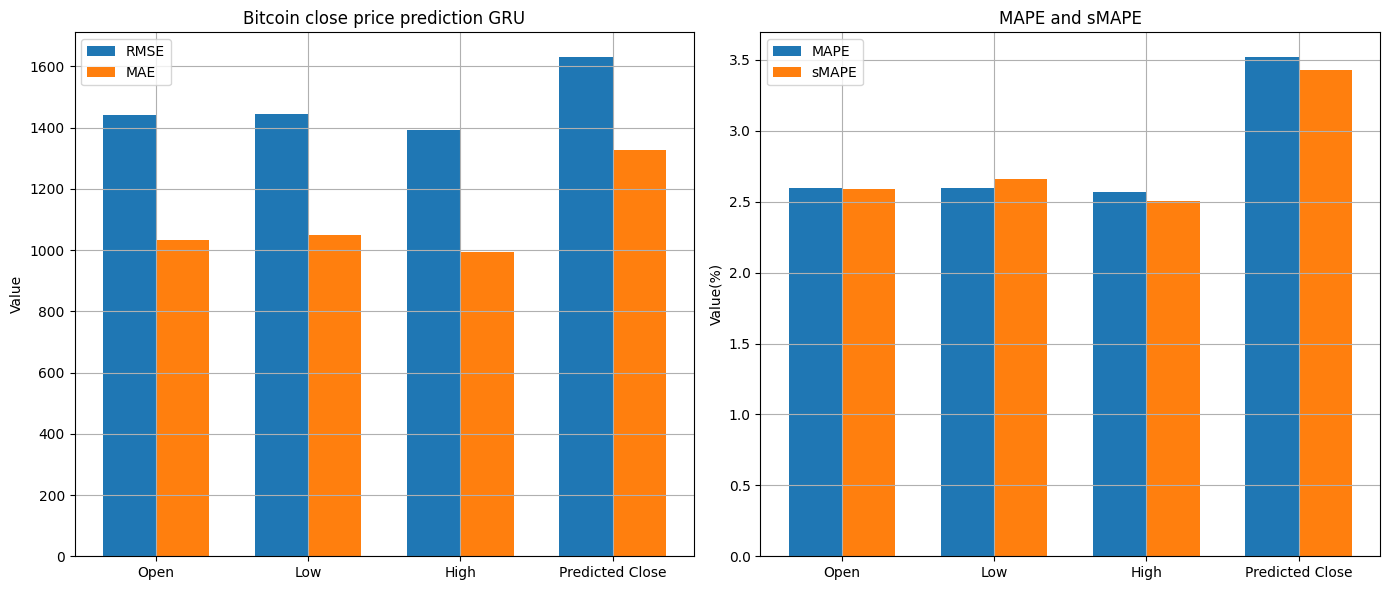

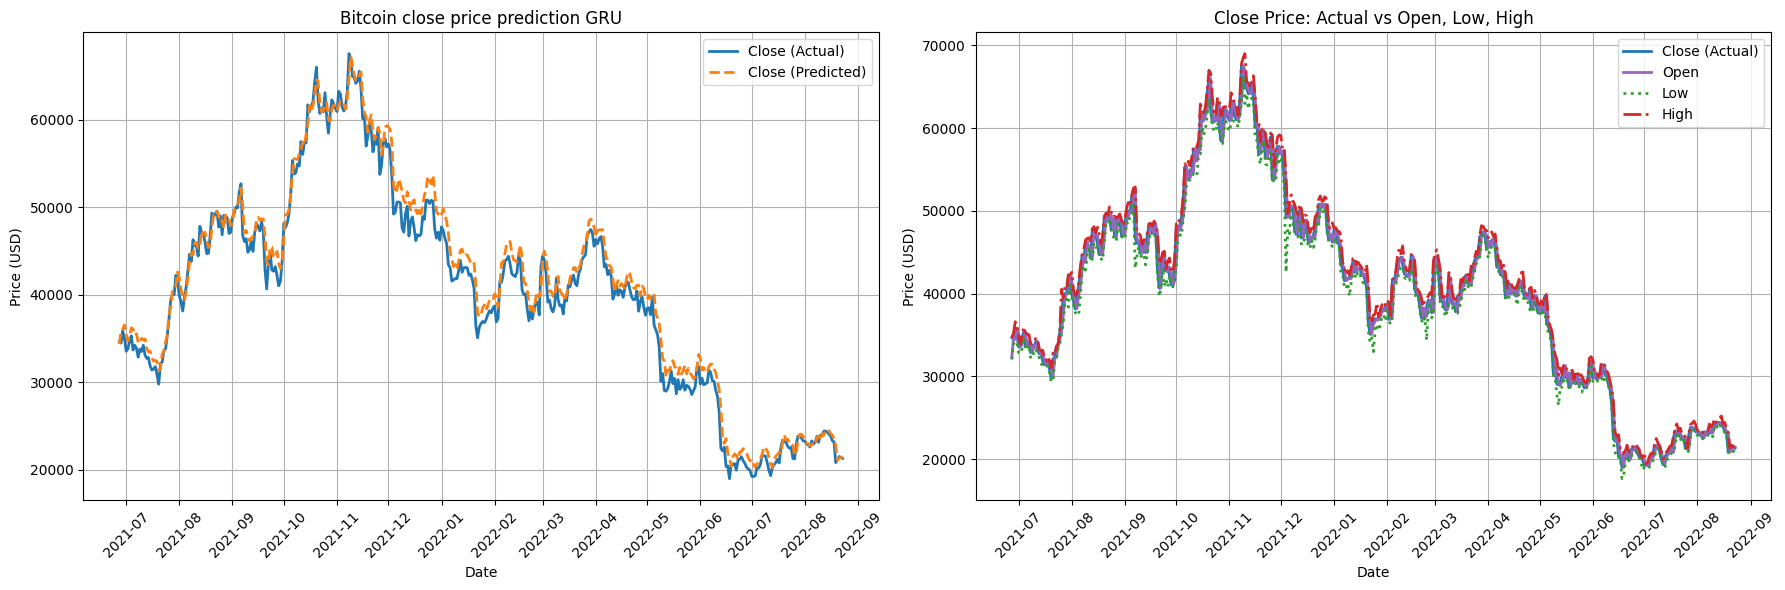

14/14 [==============================] - 0s 3ms/step
Finding model BiGRU in Bitcoin close price prediction LSTM
Finding model GRU in Bitcoin close price prediction LSTM
Finding model LSTM in Bitcoin close price prediction LSTM
defaultdict(<class 'list'>, {'Open': [1439.6225984709913, 1033.8569739952718, 2.5959391853058618, 2.5864477561559465], 'Low': [1443.698100934896, 1050.4290780141844, 2.599630026094542, 2.6622370378728224], 'High': [1393.7700289987672, 993.2243498817968, 2.5673088590443736, 2.5050443912615736], 'Predicted Close': [1489.710679146539, 1226.3721012485219, 3.2862424418197596, 3.2157812061503344]})


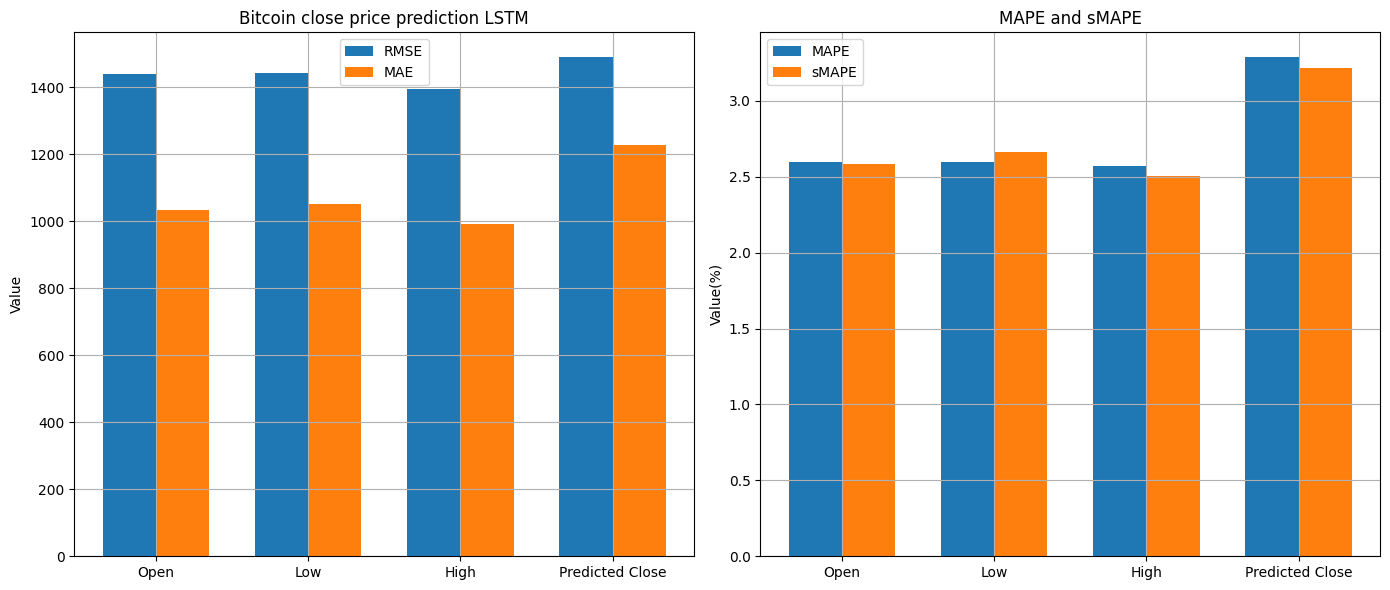

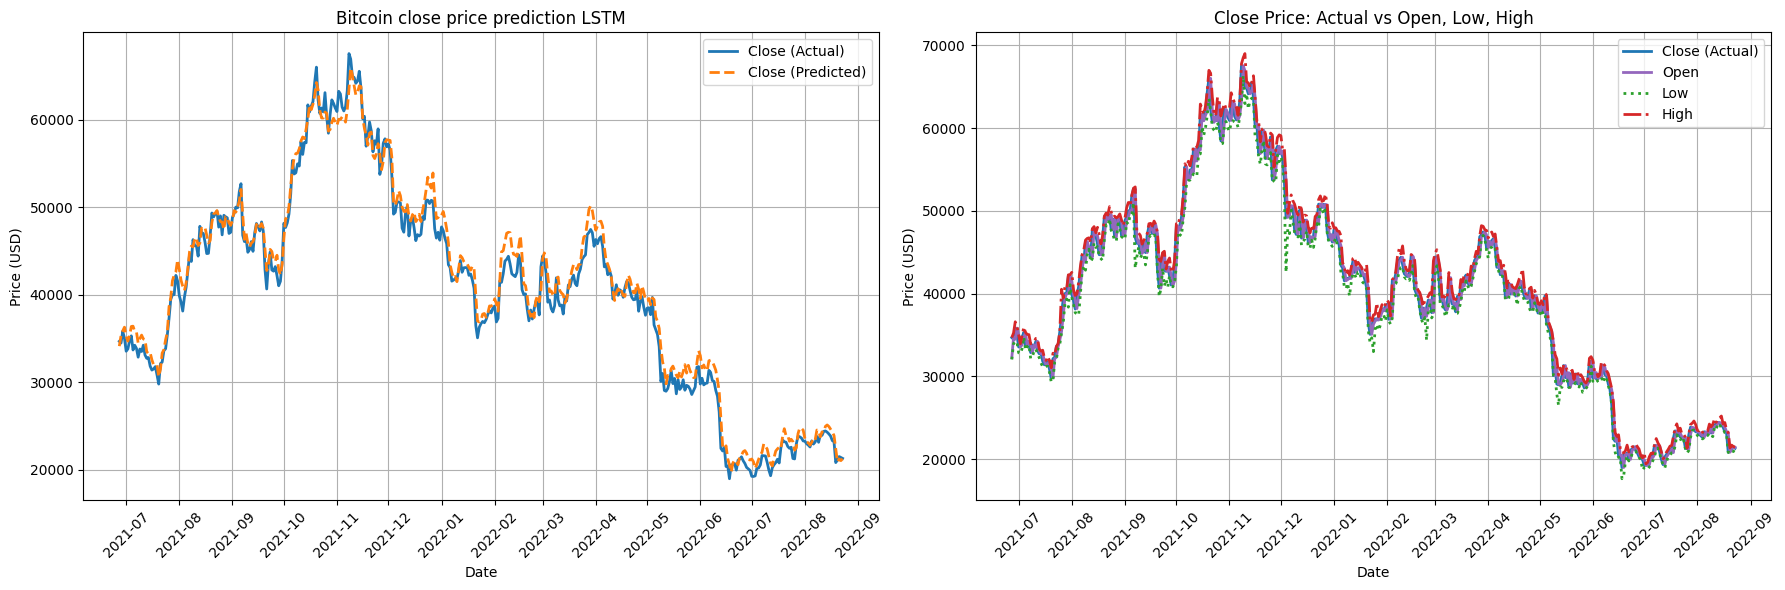

14/14 [==============================] - 1s 3ms/step
Finding model BiGRU in Bitcoin close price prediction BiGRU
defaultdict(<class 'list'>, {'Open': [1439.6225984709913, 1033.8569739952718, 2.5959391853058618, 2.5864477561559465], 'Low': [1443.698100934896, 1050.4290780141844, 2.599630026094542, 2.6622370378728224], 'High': [1393.7700289987672, 993.2243498817968, 2.5673088590443736, 2.5050443912615736], 'Predicted Close': [5210.418430750075, 4770.113823322989, 11.478657522783617, 10.813917094886568]})


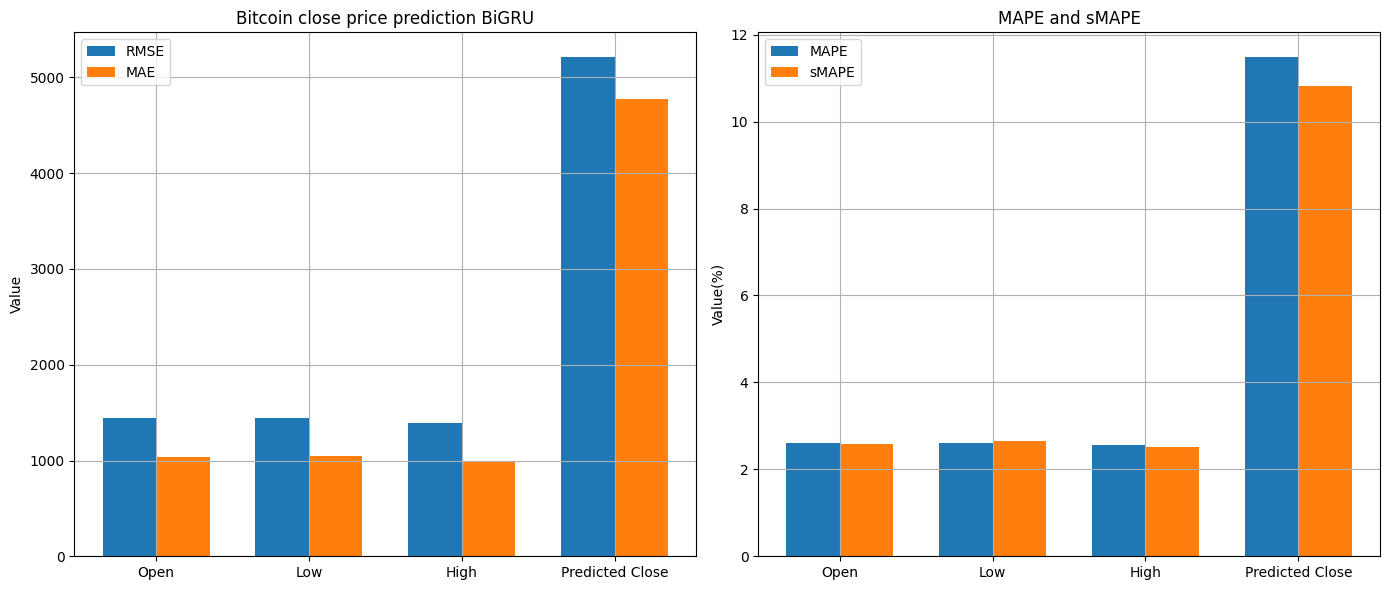

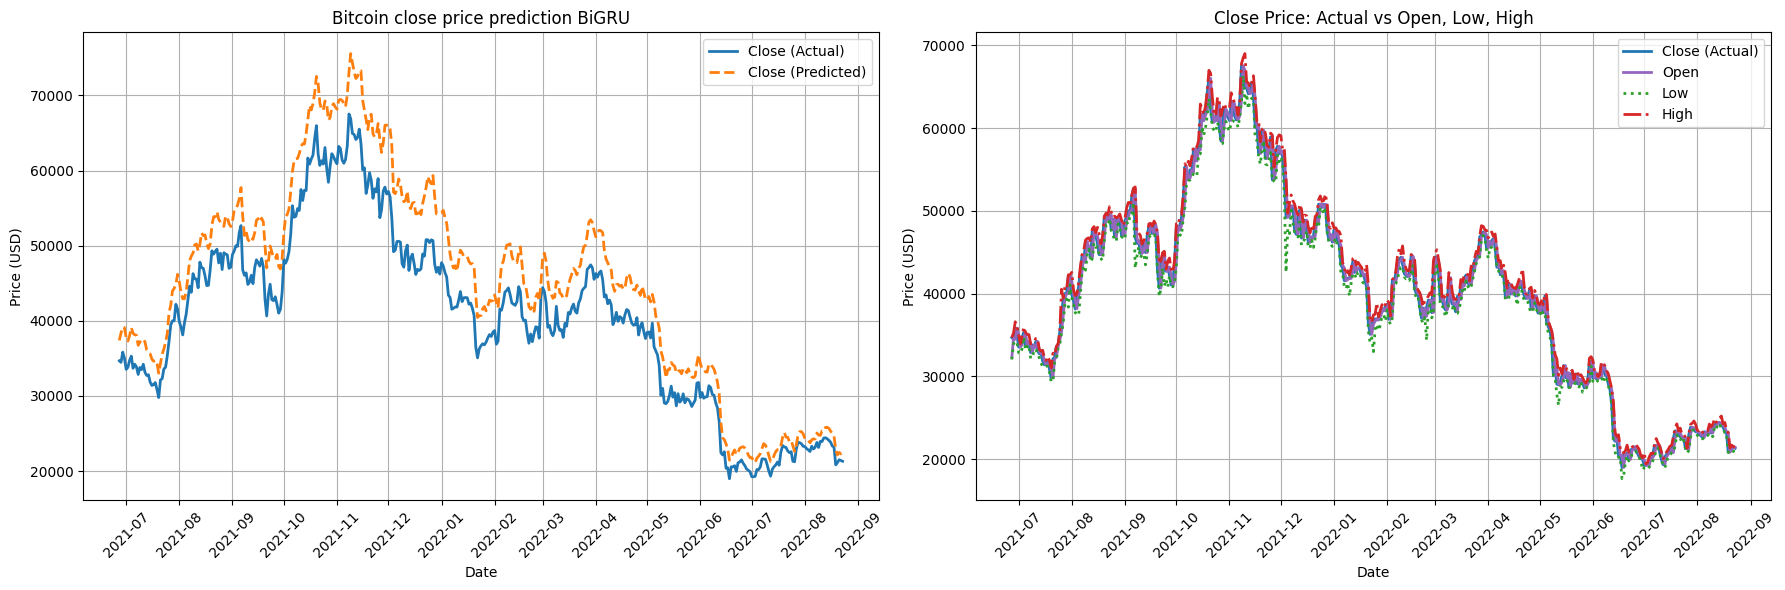

In [85]:
features = ['Low', 'High', 'Open', 'Daily_Return', 'RSI', 'SMA_50']
target   = 'Close'

model_trainer_1 = ModelTrainer()
model_trainer_1.set_train_val_test_split(0.80, 0.10)
model_trainer_1.set_features_and_target(features, target)
model_trainer_1.set_dataframe(df_bitcoin_2_clean.copy())
x_train_scaled_shape = model_trainer_1.get_x_train_shape()

# Build the model 1
model1 = Sequential([
    GRU(416, return_sequences=True, input_shape=(x_train_scaled_shape[1], x_train_scaled_shape[2])),
    Dropout(0.0),
    GRU(512),
    Dropout(0.0),
    Dense(1)
])

# Build the model 2
model2 = Sequential([
    LSTM(448, return_sequences=True, input_shape=(x_train_scaled_shape[1], x_train_scaled_shape[2])),
    Dropout(0.4),
    LSTM(480),
    Dropout(0.0),
    Dense(1)
])

# Build the model 3
model3 = Sequential([
    Bidirectional(GRU(416, return_sequences=True), input_shape=(x_train_scaled_shape[1], x_train_scaled_shape[2])),
    Dropout(0.40),
    Bidirectional(GRU(192)),  # Note: return_sequences defaults to False here
    Dropout(0.40),
    Dense(1)
])

models = [model1, model2, model3]
model_trainer_1.set_models(models)

# -------------RUN-----------------
model_trainer_1.run()
#---------------------------------

### Investigating Feature selection

1. Here we investigate whether closing prices of other popular cryptocurrency coins can help improve our model. 

2. Other cryptos prices have data from 2016-2022, therefore we reduce the size of our bitcoin dataset to match these dates. 

3. We perform training on period 2 (2016-2022).

4. Again we use the correlation heatmap and XGBoost algorithm to find the most important features. 

Important features for period 22191 without popular cyrpocurrency prices:

Cross-validation scores (MSE): [2.82707897e+07 3.50980266e+04 2.43692957e+04 5.20765015e+08
 2.29245005e+06]
Mean cross-validation score (MSE): 110277544.4091079
Feature ranking for bitcoin_Close:
1. feature Low (0.653615415096283)
2. feature High (0.34557342529296875)
3. feature Open (0.00022800095030106604)
4. feature Daily_Return (0.0002061874547507614)
5. feature SMA_50 (0.00012624413648154587)
6. feature EMA_50 (5.1861079555237666e-05)
7. feature Volatility (4.163000266999006e-05)
8. feature RSI (3.8563815905945376e-05)
9. feature Signal_Line (2.8327991458354518e-05)
10. feature Volume (2.7228801627643406e-05)
11. feature SMA_200 (2.7037305699195713e-05)
12. feature MACD (1.8238673874293454e-05)
13. feature EMA_200 (1.790645364962984e-05)
14. feature Price_Direction (0.0)
Open               2191
High               2191
Low                2191
bitcoin_Close      2191
Volume             2191
SMA_50           

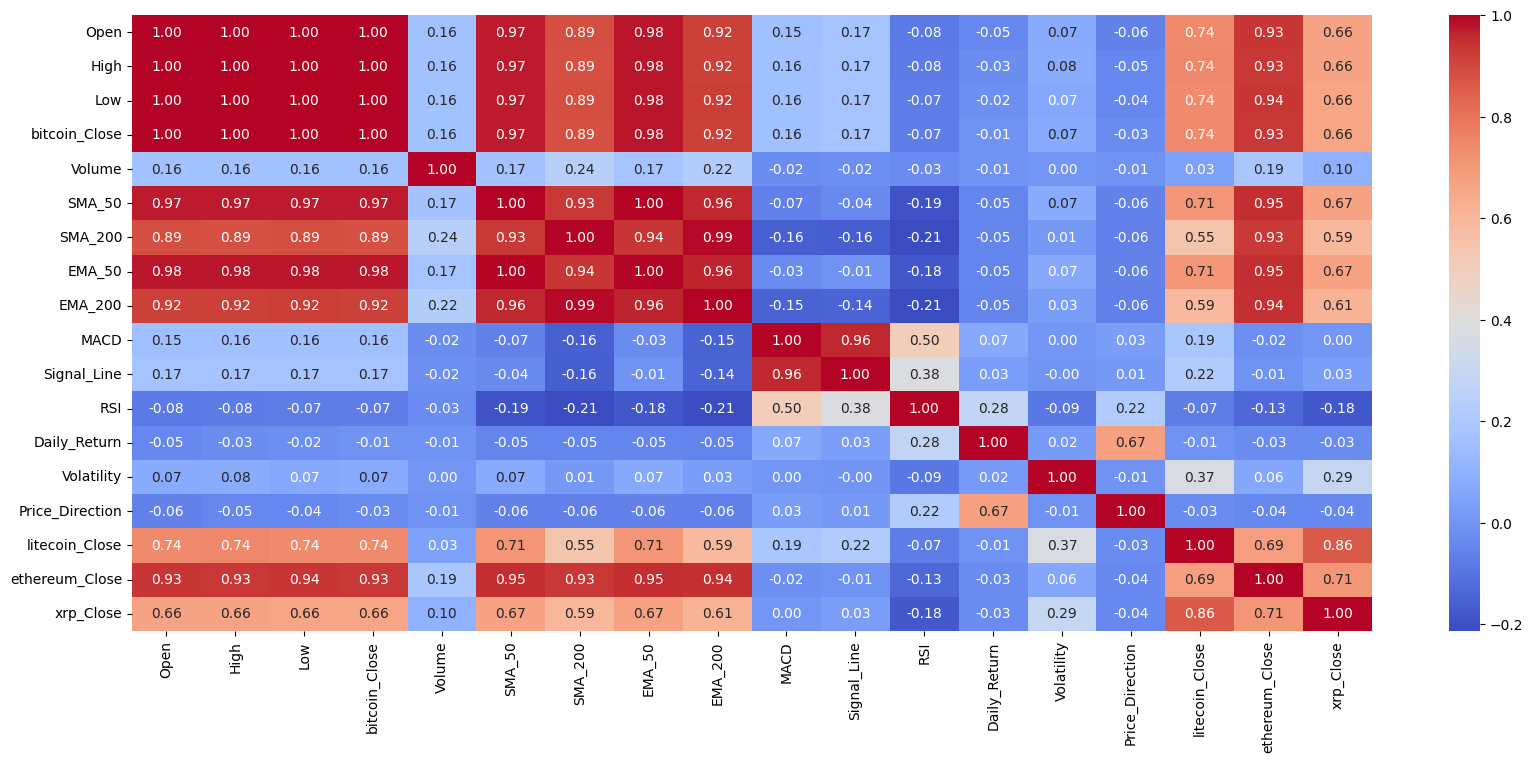

                 bitcoin_Close
bitcoin_Close         1.000000
High                  0.999355
Low                   0.999227
Open                  0.998540
EMA_50                0.979260
SMA_50                0.972914
ethereum_Close        0.933197
EMA_200               0.917142
SMA_200               0.885171
litecoin_Close        0.742338
xrp_Close             0.663275
Signal_Line           0.173883
Volume                0.162915
MACD                  0.159929
Volatility            0.073214
Daily_Return         -0.006410
Price_Direction      -0.032439
RSI                  -0.071419
Important features for period 22191 with popular cyrpocurrency prices:

Cross-validation scores (MSE): [2.81362244e+07 4.72832188e+04 2.65230582e+04 5.22406348e+08
 4.84932091e+06]
Mean cross-validation score (MSE): 111093139.92879029
Feature ranking for bitcoin_Close:
1. feature Low (0.6701481938362122)
2. feature High (0.32886335253715515)
3. feature Daily_Return (0.00022822081518825144)
4. feature Open (0

In [86]:
df_bitcoin_features = df_bitcoin_2_clean.copy()
df_bitcoin_features = df_bitcoin_features.drop(['Currency'], axis=1)
df_bitcoin_features = df_bitcoin_features.rename(columns={'Close': 'bitcoin_Close'})
cryptos_prices_to_copy = ['litecoin', 'ethereum', 'xrp']

# Find the latest starting date among all the cryptocurrencies
latest_start_date = max(df.index.min() for df in [df_bitcoin_features] + [dfs[f'raw_{crypto}_pd'] for crypto in cryptos_prices_to_copy])

# Filter df_bitcoin_features from the latest start date onwards
df_bitcoin_features = df_bitcoin_features[df_bitcoin_features.index >= latest_start_date]

print(f"Important features for period 2{len(df_bitcoin_features)} without popular cyrpocurrency prices:\n")
feature_importance_verifier(df_bitcoin_features.copy(), 'bitcoin_Close')
for crypto in cryptos_prices_to_copy:
    # Filter each crypto DataFrame from the latest start date onwards and add 'Close' price to df_bitcoin_features
    df_bitcoin_features[f'{crypto}_Close'] = dfs[f'raw_{crypto}_pd'].loc[dfs[f'raw_{crypto}_pd'].index >= latest_start_date, 'Close']

print(df_bitcoin_features.count())

# Calculate the correlation matrix
correlation_matrix = df_bitcoin_features.corr()
correlation_with_target = correlation_matrix[['bitcoin_Close']].sort_values(by='bitcoin_Close', ascending=False)
plt.figure(figsize=(20, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.show()
print(correlation_with_target)
print(f"Important features for period 2{len(df_bitcoin_features)} with popular cyrpocurrency prices:\n")
feature_importance_verifier(df_bitcoin_features.copy(), 'bitcoin_Close')


### Building models for period 2(2016-2022) using popular cryptocurrency prices:

1. We choose the eight most important features 'Low', 'High', 'Open', 'Daily_Return', 'SMA_50', 'ethereum_Close', 'EMA_50', 'litecoin_Close'.

2. We build the three models GRU, LSTM and BiGRU as previosly and use hyperparameters obtained from hyperparameters tuning. 

7/7 [==============================] - 0s 3ms/step
Finding model BiGRU in Bitcoin close price prediction GRU
Finding model GRU in Bitcoin close price prediction GRU
defaultdict(<class 'list'>, {'Open': [1211.6735359148367, 839.9963636363639, 2.600790404063018, 2.5831663681119847], 'Low': [1135.8445977253305, 798.8463636363635, 2.4673456568333396, 2.52858214393246], 'High': [1205.7161981200595, 865.5431818181818, 2.7419889224693, 2.669910950815961], 'Predicted Close': [229.46592045368178, 186.19900923295447, 0.5900131741990511, 0.5914108067957466]})


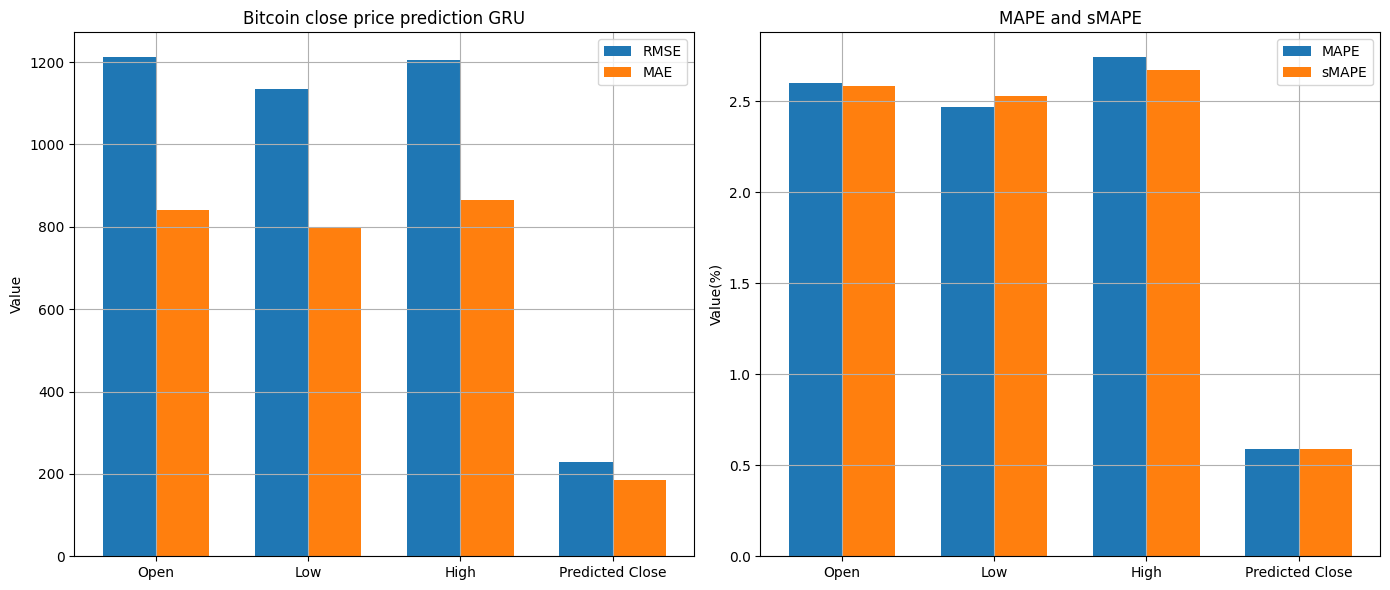

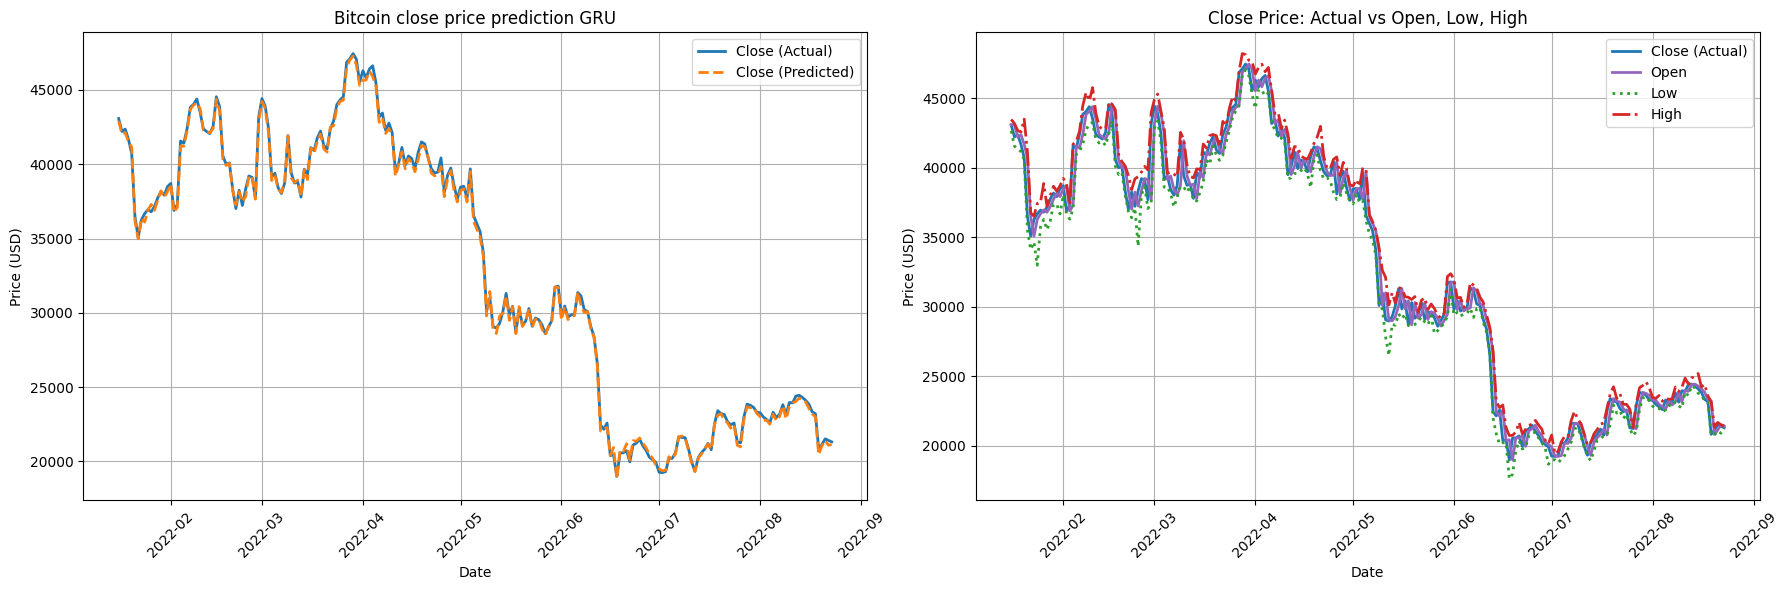

7/7 [==============================] - 0s 4ms/step
Finding model BiGRU in Bitcoin close price prediction LSTM
Finding model GRU in Bitcoin close price prediction LSTM
Finding model LSTM in Bitcoin close price prediction LSTM
defaultdict(<class 'list'>, {'Open': [1211.6735359148367, 839.9963636363639, 2.600790404063018, 2.5831663681119847], 'Low': [1135.8445977253305, 798.8463636363635, 2.4673456568333396, 2.52858214393246], 'High': [1205.7161981200595, 865.5431818181818, 2.7419889224693, 2.669910950815961], 'Predicted Close': [965.5909284650036, 767.705459872159, 2.639554360620678, 2.580177714532291]})


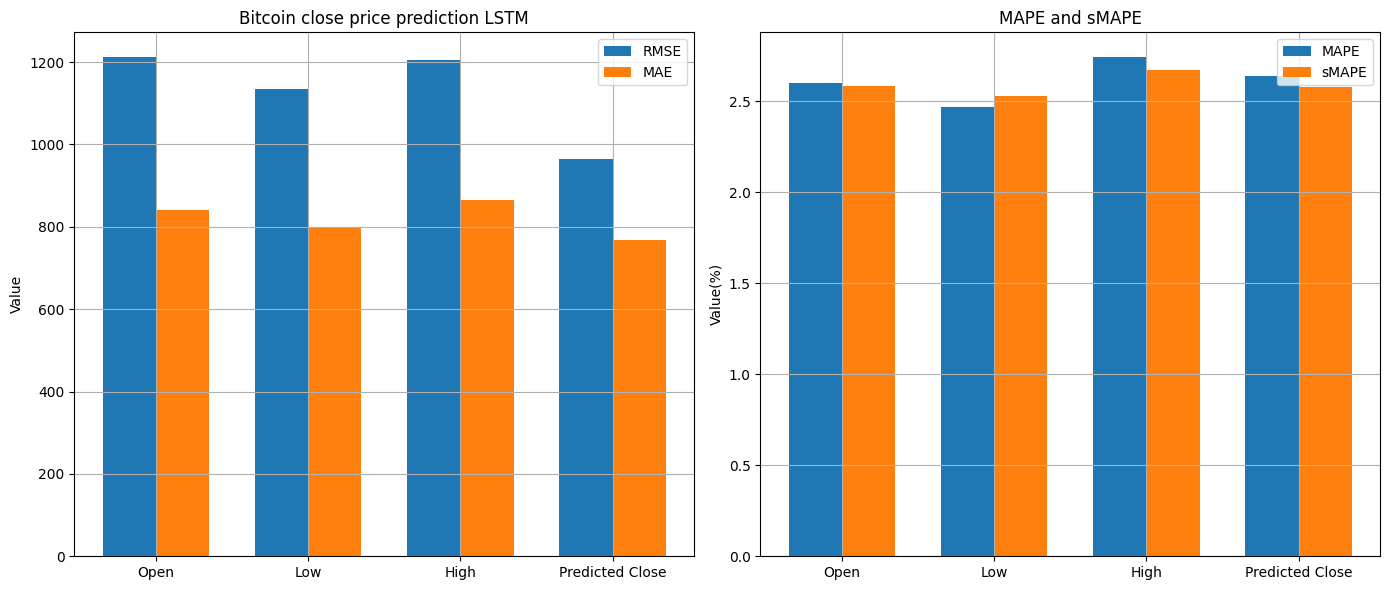

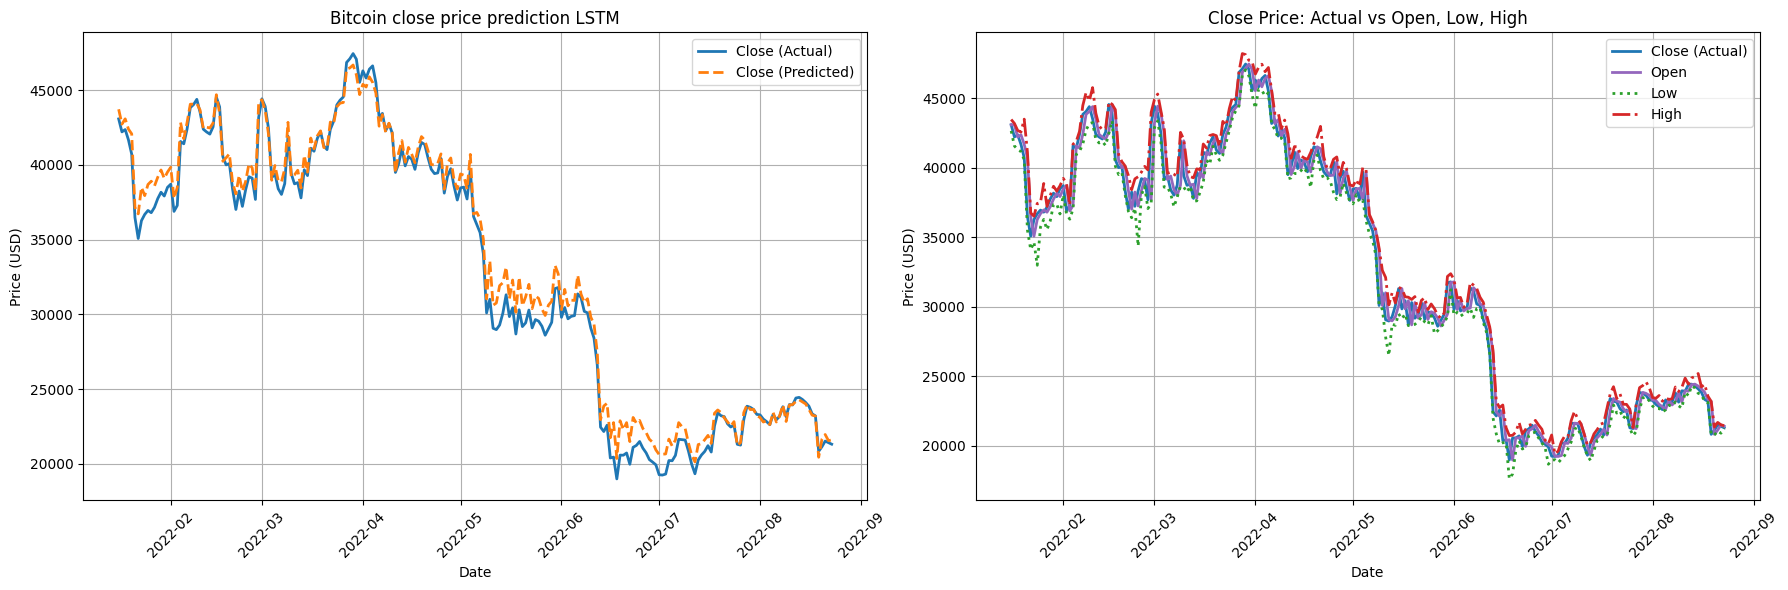

7/7 [==============================] - 1s 4ms/step
Finding model BiGRU in Bitcoin close price prediction BiGRU
defaultdict(<class 'list'>, {'Open': [1211.6735359148367, 839.9963636363639, 2.600790404063018, 2.5831663681119847], 'Low': [1135.8445977253305, 798.8463636363635, 2.4673456568333396, 2.52858214393246], 'High': [1205.7161981200595, 865.5431818181818, 2.7419889224693, 2.669910950815961], 'Predicted Close': [544.4296828824857, 443.077958096591, 1.4835302071948946, 1.4702236172056375]})


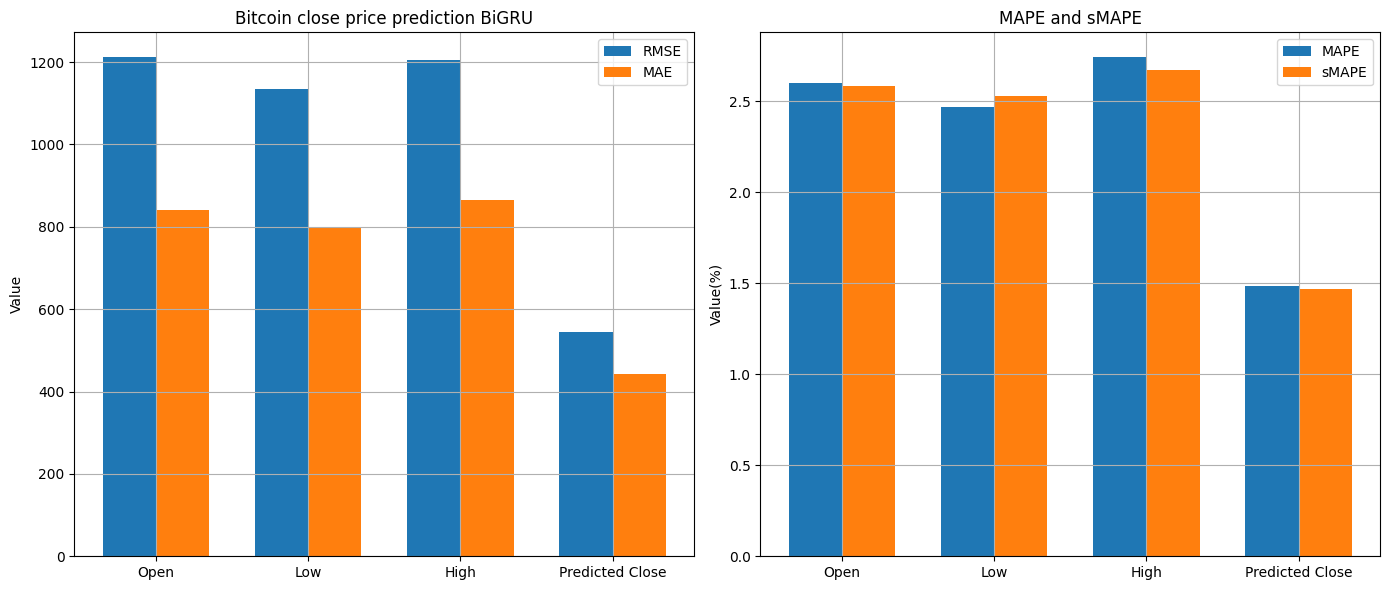

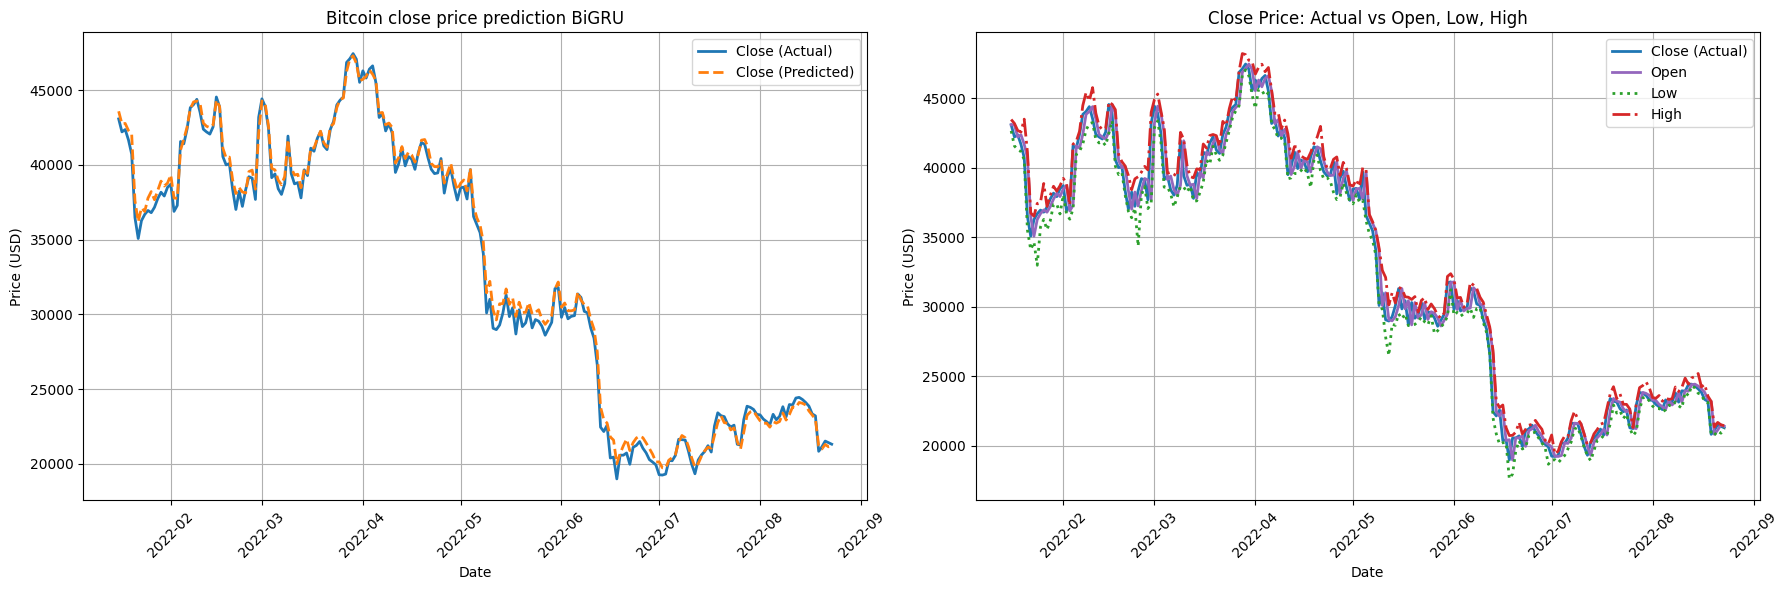

In [87]:
features = ['Low', 'High', 'Open', 'Daily_Return', 'SMA_50', 'ethereum_Close', 'EMA_50', 'litecoin_Close']
target   = 'bitcoin_Close'

model_trainer_2 = ModelTrainer()
model_trainer_2.set_train_val_test_split(0.80, 0.10)
model_trainer_2.set_features_and_target(features, target)
model_trainer_2.set_dataframe(df_bitcoin_features.copy())
x_train_scaled_shape = model_trainer_2.get_x_train_shape()

# Build the model 1
model1 = Sequential([
    GRU(416, return_sequences=True, input_shape=(x_train_scaled_shape[1], x_train_scaled_shape[2])),
    Dropout(0.0),
    GRU(512),
    Dropout(0.0),
    Dense(1)
])

# Build the model 2
model2 = Sequential([
    LSTM(448, return_sequences=True, input_shape=(x_train_scaled_shape[1], x_train_scaled_shape[2])),
    Dropout(0.4),
    LSTM(480),
    Dropout(0.0),
    Dense(1)
])

# Build the model 3
model3 = Sequential([
    Bidirectional(GRU(416, return_sequences=True), input_shape=(x_train_scaled_shape[1], x_train_scaled_shape[2])),
    Dropout(0.40),
    Bidirectional(GRU(192)),  # Note: return_sequences defaults to False here
    Dropout(0.40),
    Dense(1)
])

models = [model1, model2, model3]
model_trainer_2.set_models(models)

# -------------RUN-----------------
model_trainer_2.run()
#---------------------------------

### Building models for period 2(2016-2022) without using popular cryptocurrency prices:

1. We choose the six most important features 'Low', 'High', 'Open', 'Daily_Return', 'SMA_50', 'EMA_50', we remove the popular cryptocurrency prices to isolate their effects.

2. We build the three models GRU, LSTM and BiGRU as previosly and use hyperparameters obtained from hyperparameters tuning. 

7/7 [==============================] - 0s 3ms/step
Finding model BiGRU in Bitcoin close price prediction GRU
Finding model GRU in Bitcoin close price prediction GRU
defaultdict(<class 'list'>, {'Open': [1211.6735359148367, 839.9963636363639, 2.600790404063018, 2.5831663681119847], 'Low': [1135.8445977253305, 798.8463636363635, 2.4673456568333396, 2.52858214393246], 'High': [1205.7161981200595, 865.5431818181818, 2.7419889224693, 2.669910950815961], 'Predicted Close': [387.21432895133046, 339.78684481534094, 1.056226435600721, 1.0494938771444782]})


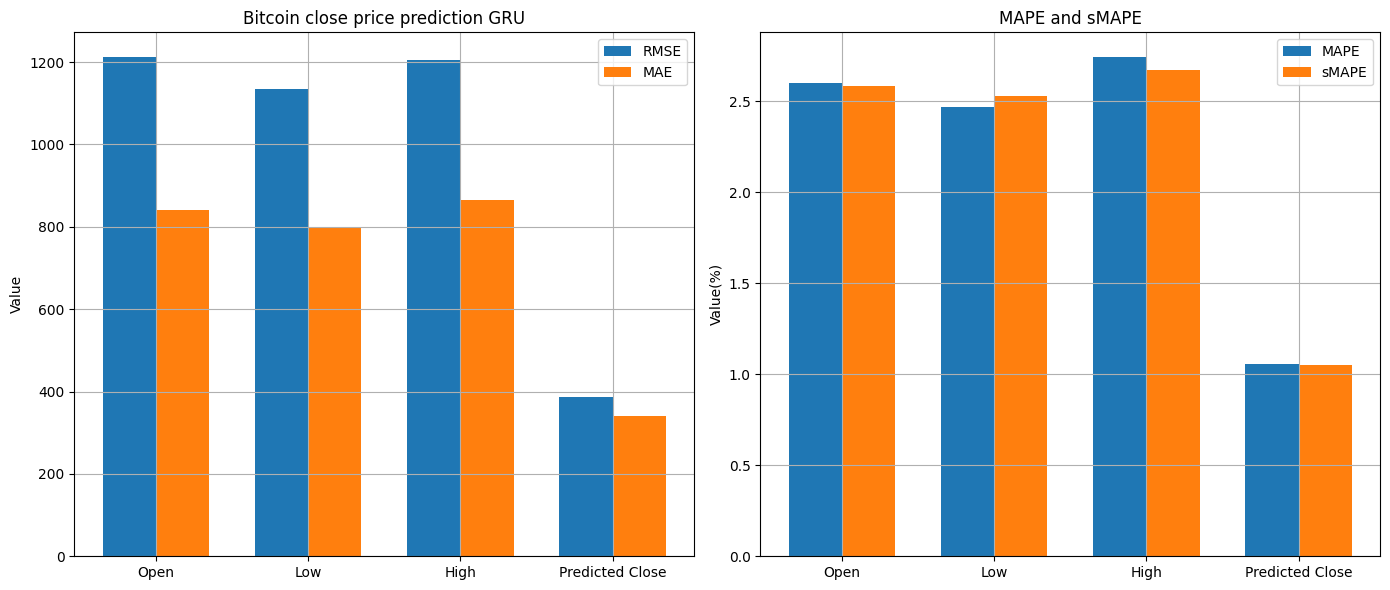

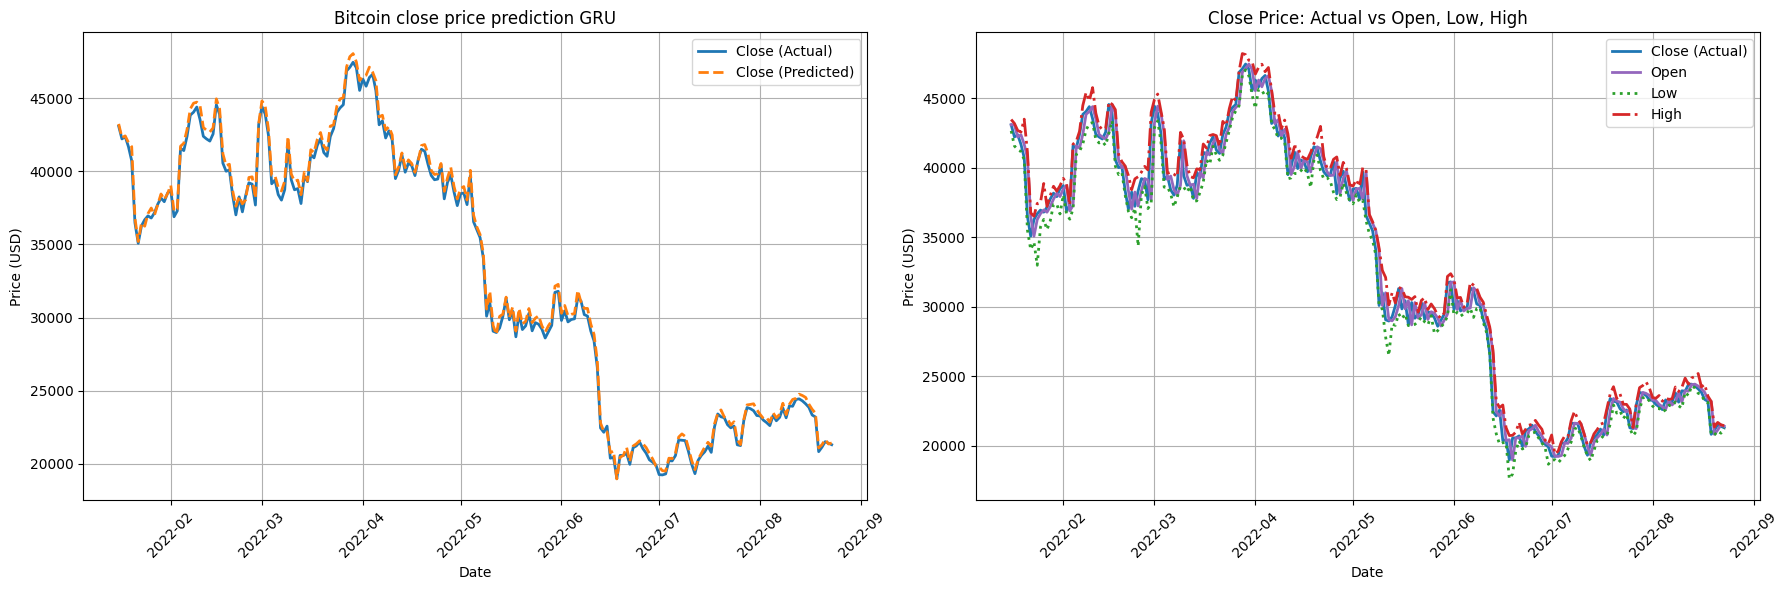

7/7 [==============================] - 0s 4ms/step
Finding model BiGRU in Bitcoin close price prediction LSTM
Finding model GRU in Bitcoin close price prediction LSTM
Finding model LSTM in Bitcoin close price prediction LSTM
defaultdict(<class 'list'>, {'Open': [1211.6735359148367, 839.9963636363639, 2.600790404063018, 2.5831663681119847], 'Low': [1135.8445977253305, 798.8463636363635, 2.4673456568333396, 2.52858214393246], 'High': [1205.7161981200595, 865.5431818181818, 2.7419889224693, 2.669910950815961], 'Predicted Close': [475.36235786387954, 398.69356711647725, 1.2159519863617063, 1.2067258428678878]})


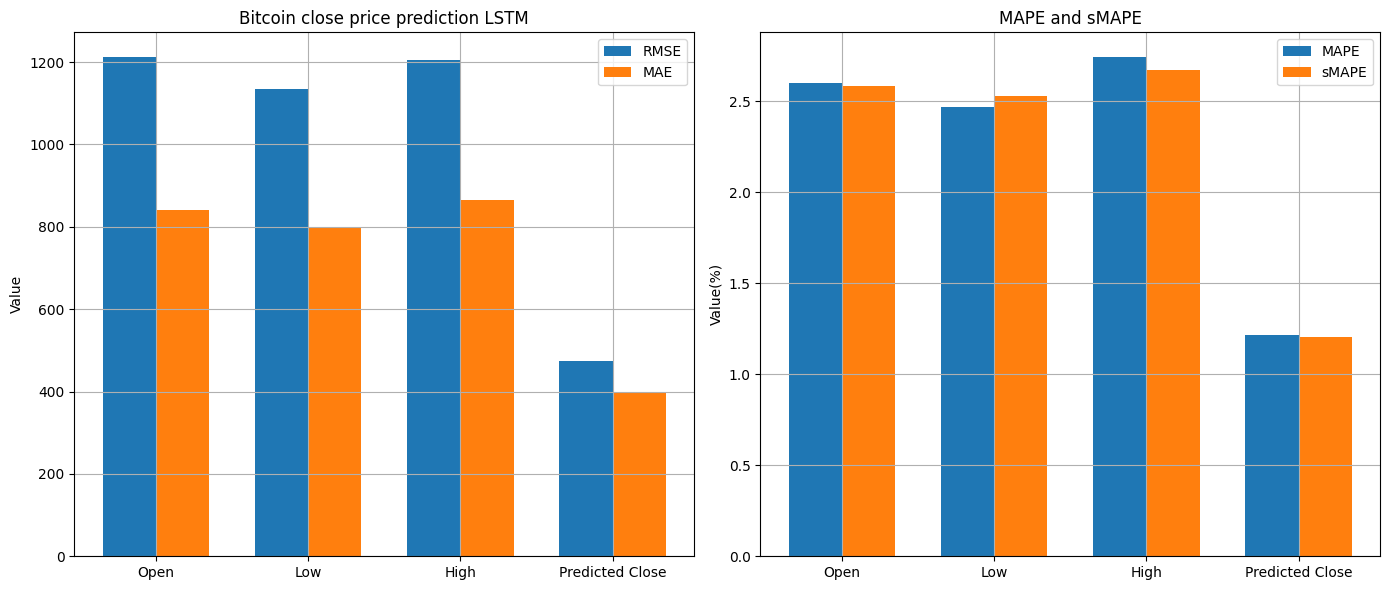

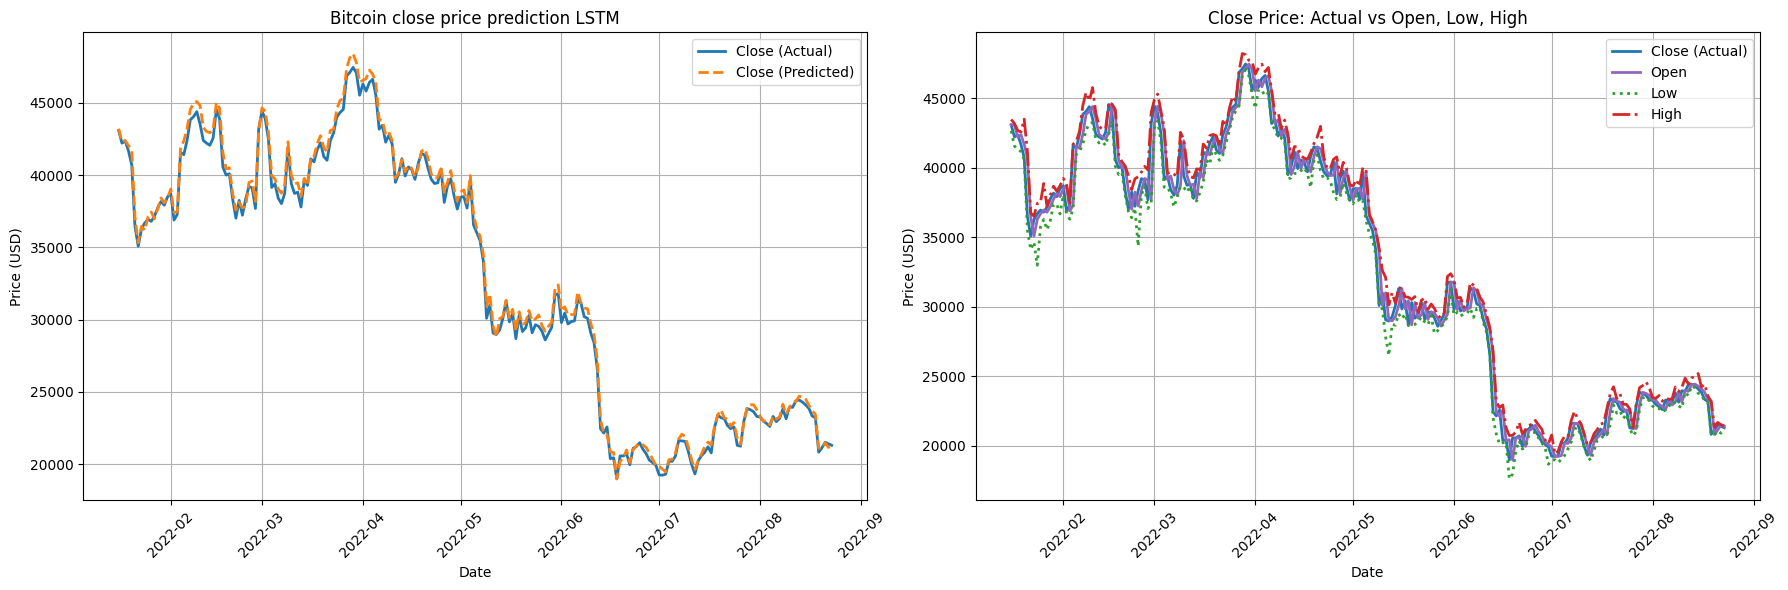

7/7 [==============================] - 1s 4ms/step
Finding model BiGRU in Bitcoin close price prediction BiGRU
defaultdict(<class 'list'>, {'Open': [1211.6735359148367, 839.9963636363639, 2.600790404063018, 2.5831663681119847], 'Low': [1135.8445977253305, 798.8463636363635, 2.4673456568333396, 2.52858214393246], 'High': [1205.7161981200595, 865.5431818181818, 2.7419889224693, 2.669910950815961], 'Predicted Close': [731.2858433162077, 668.3581764914773, 2.168219953343138, 2.1397782780728565]})


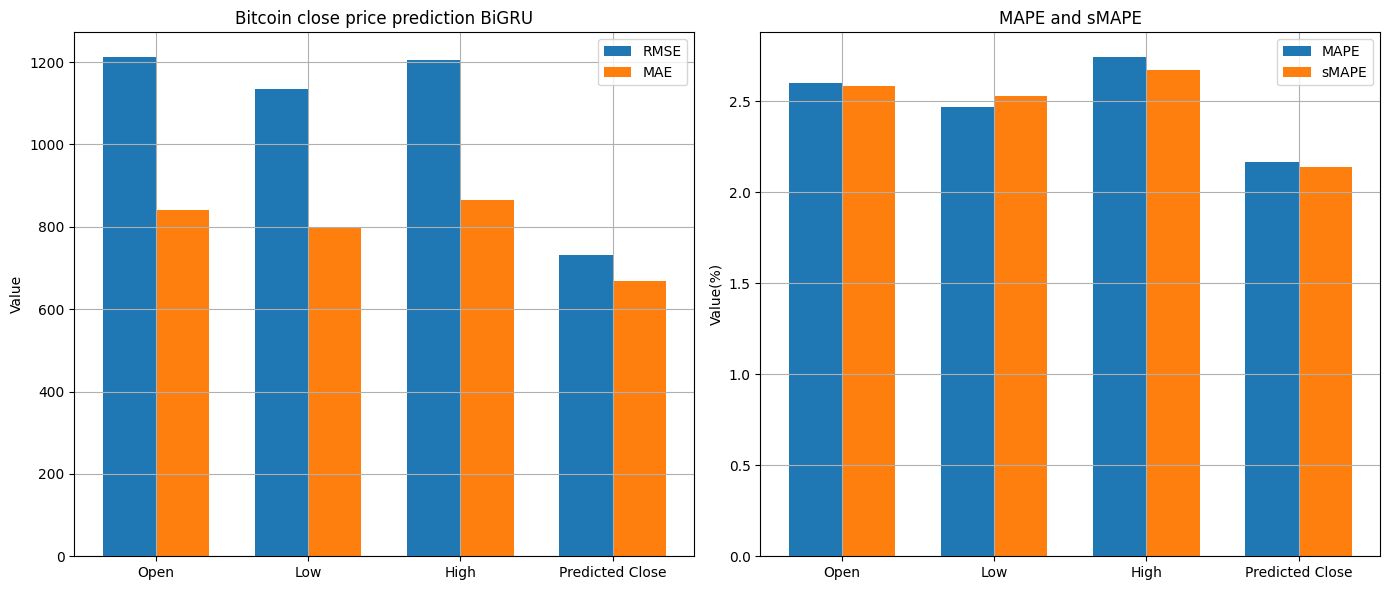

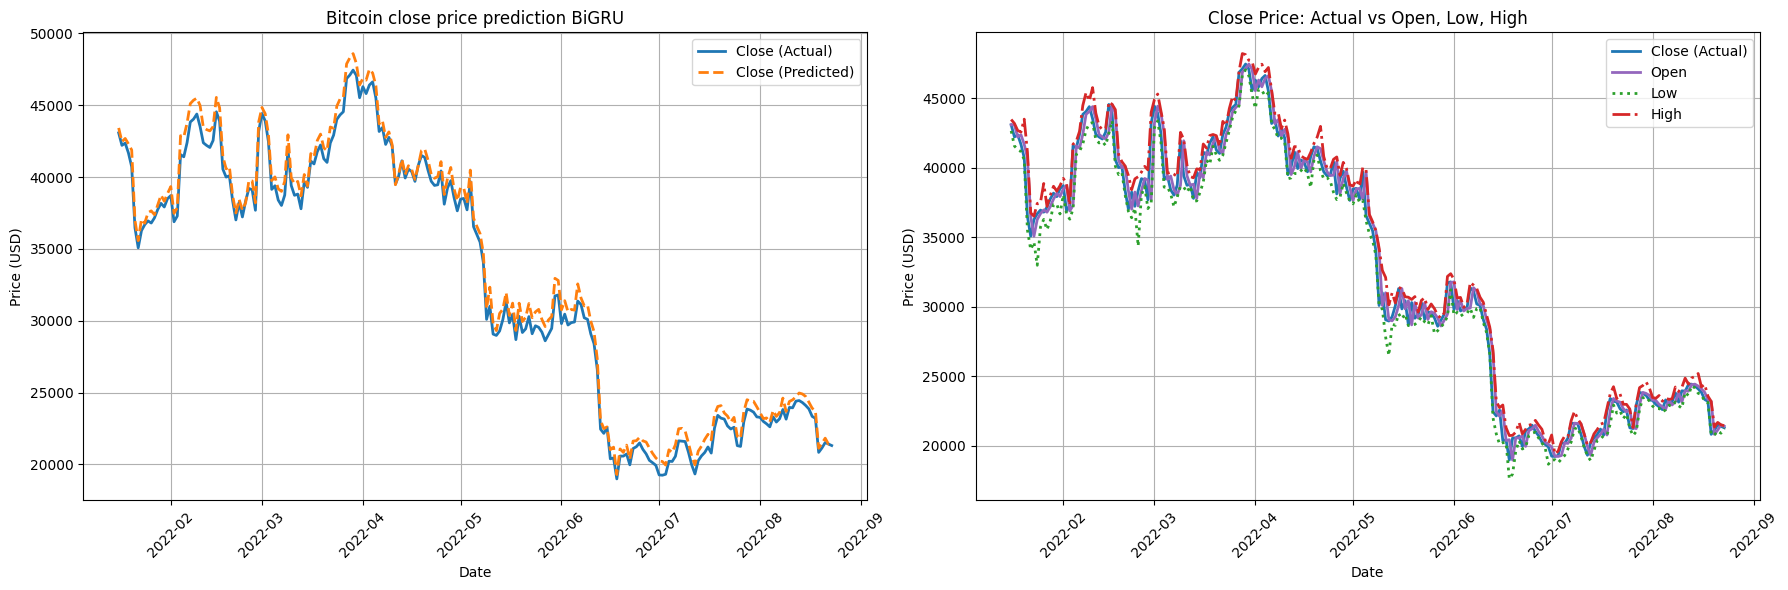

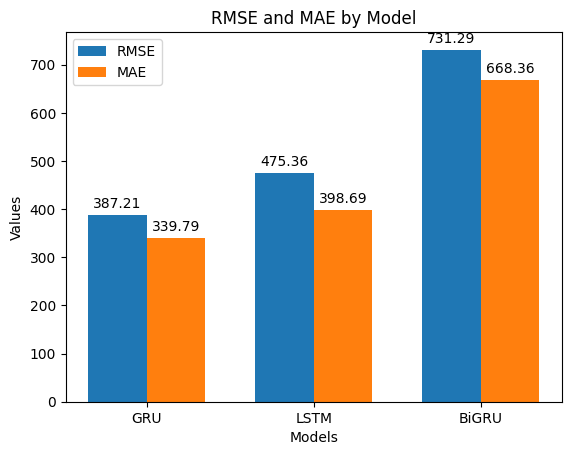

In [88]:
features = ['Low', 'High', 'Open', 'Daily_Return', 'RSI', 'SMA_50']
target   = 'bitcoin_Close'

model_trainer_3 = ModelTrainer()
model_trainer_3.set_train_val_test_split(0.80, 0.10)
model_trainer_3.set_features_and_target(features, target)
model_trainer_3.set_dataframe(df_bitcoin_features.copy())
x_train_scaled_shape = model_trainer_3.get_x_train_shape()

# Build the model 1
model1 = Sequential([
    GRU(416, return_sequences=True, input_shape=(x_train_scaled_shape[1], x_train_scaled_shape[2])),
    Dropout(0.0),
    GRU(512),
    Dropout(0.0),
    Dense(1)
])

# Build the model 2
model2 = Sequential([
    LSTM(448, return_sequences=True, input_shape=(x_train_scaled_shape[1], x_train_scaled_shape[2])),
    Dropout(0.4),
    LSTM(480),
    Dropout(0.0),
    Dense(1)
])

# Build the model 3
model3 = Sequential([
    Bidirectional(GRU(416, return_sequences=True), input_shape=(x_train_scaled_shape[1], x_train_scaled_shape[2])),
    Dropout(0.40),
    Bidirectional(GRU(192)),  # Note: return_sequences defaults to False here
    Dropout(0.40),
    Dense(1)
])

models = [model1, model2, model3]
model_trainer_3.set_models(models)

# -------------RUN-----------------
model_trainer_3.run()
#---------------------------------

model_trainer_3.plot_model_metrics()

### Results and Analysis Round up

**Objectives recap:**

1. Use machine/deep learning to predict bitcoin closing price in USD(United States Dollar). 
2. Investigate which features are the most important when it comes to making the above prediction. 

**Results summary:**

1. Our models trained on Period 1(2011-2022) produced slightly better predictions than the Open/Low/High features. GRU model performed the best out of the three in terms of RMSE and MAE. 
2. Prices of other popular cryptocurrency such as Ethereum and Litecoin did not improve model's predictions. However, changing the training and validation data set closer to an event taking place(such as COVID-19 era) did improve performance. For example our models trained for Period(2016-2022) produced the best performance. In period 2 the GRU model performed the best in terms of RMSE/MAE. 
3. The most important features for predicting Bitcoin's closing price were 'Low', 'High', 'Open', 'Daily_Return', 'SMA_50(simple moving average 50 days)', 'EMA_50(exponential moving average 50 days)'.


# ML Challenges and Limitations 

1. Our models were using features such as Open/Low/High prices for Bitcoin to make predictions for the closing price.  In a real life scenario it could be possible that these features are not available to make predictions for the future. Therefore the usage of this model could be limited in an algorithmic trading scenario. 

2. Our models for period 1 (2011-2016) produced only slightly better predictions than the Open/High/Low however the model almost always was able to get the overall trend and price direction of Bitcoin correct. This could be advantageous in a longer trading strategy where predicting the price direction or trend is more important than the closing price itself. 

3. When our model was trained on more recent data(period 2), its performance improved significantly. From our project we can conclude that recent data may be more important for training our models for future predictions rather than using the entire historical dataset. 


### Further research and potential improvements

1. We can apply another approach for predicting the Bitcoin price. One popular method is called the "CEEDMAN decomposition". Here we would split our target variable which is the closing price into seperate IMFs and train models to predict these IMFs. Aggregating the IMF predictions would give us our Bitcoin closing price. This method could potentially improve prediction accuracy. 

2. Cryptocurrency prices can be influenced by many other economic factors such as price of oil and gold. A deeper investigation into feature selection could improve our model where we would likely require data from outside the Kaggle website. 

3. Cryptocurrency prices are also in many cases effected by sentiment such as tweets, google searches/trends and online forums. Sentiment analysis could also be an important factor in improving the model's accuracy. Here we would most likely require data outside of the Kaggle website. 

### Sentiment analysis 

This involves analyzing the text of news articles, social media posts, and other textual data to determine the sentiment (positive, negative, neutral) expressed about a particular cryptocurrency. This sentiment can then be used as an input feature to our model. The intuition is that positive news might lead to price increases, while negative news might cause prices to drop. This requires a pipeline that can:

1. Continuously scrape or receive news data from various sources.

2. Preprocess the text data (tokenization, removing stop words, etc.).

3. Analyze sentiment using either pre-trained models or custom models trained on labeled financial news data.


### Online learning

Online learning models are particularly useful in domains where data is continually evolving, where we want our model to adapt to the latest trends without needing a full retraining cycle.

### Example of Monero/XMR displays the limiations of our machine learning model 

At the back end of 2023, the UK government accounced new regulations with regards to cryptocurrency purchase and trading. Subsequently "Bit2me" a major player in the crypto market halted its operations in the UK[1]. At the start of 2024, other major players such as OKX and Binance decided to remove the Monero coin from their platform[2][3]. Given these advancements, subsequently the price of Monero crashed in February 2024. 

The price of Monero suffered an unprecented decline, something that is impossible to predict using a machine learning model trained on historical data. Therefore sentiment analysis and online learning would be paramount in making these predictions. 

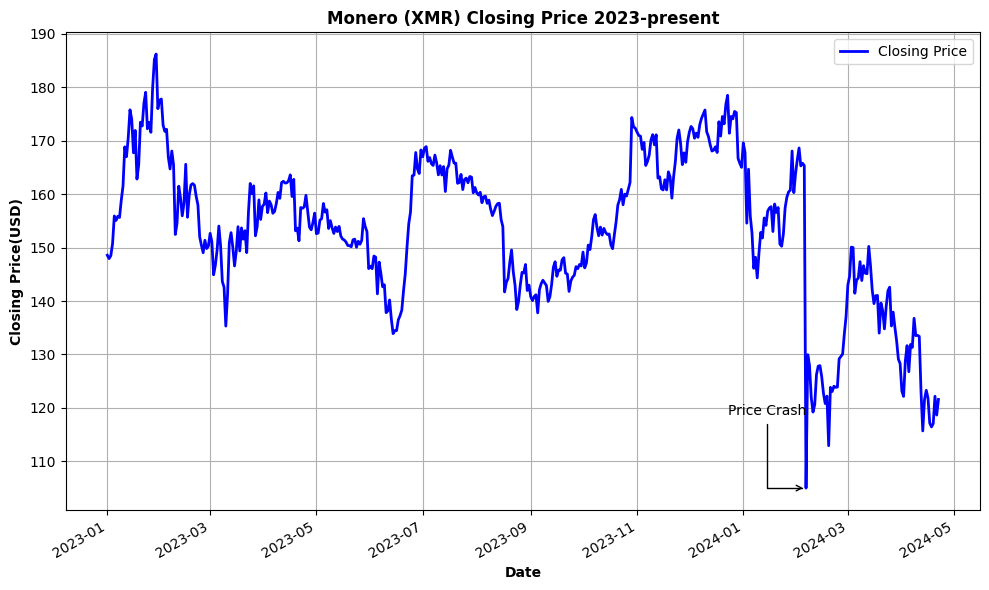

In [89]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

# Fetching the data
ticker_symbol = 'XMR-USD'  # Assuming XMR-USD is the ticker symbol
ticker_data = yf.Ticker(ticker_symbol)
ticker_df = ticker_data.history(period='max')

# Filtering the DataFrame for data from 2023 onwards
ticker_df_filtered = ticker_df[ticker_df.index.year >= 2023]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(ticker_df_filtered.index, ticker_df_filtered['Close'], label='Closing Price', color='blue', linewidth=2)

# Highlighting the price crash on 6th Feb 2024 with a vertical line
price_crash_date = pd.Timestamp('2024-02-06')

# Adding an annotation with an arrow
y_position = ticker_df_filtered['Close'].min()  # Find the minimum closing price to position the annotation at the bottom
plt.annotate('Price Crash', xy=(price_crash_date, y_position), xytext=(price_crash_date, y_position * 1.15),
             arrowprops=dict(facecolor='red', arrowstyle="->", connectionstyle="angle,angleA=-90,angleB=180,rad=0"),
             horizontalalignment='right', verticalalignment='top')

# Adding title and labels
plt.title('Monero (XMR) Closing Price 2023-present', fontweight='bold')
plt.xlabel('Date', fontweight='bold')
plt.ylabel('Closing Price(USD)', fontweight='bold')
plt.gcf().autofmt_xdate()  # Improve date labels readability
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# References

[1]Bit2Me, “Bit2Me Support,” support.bit2me.com. https://support.bit2me.com/en/support/solutions/articles/35000232952-new-regulations-for-uk-residents (accessed Apr. 22, 2024).

[2]Martin, “Monero (XMR): Why does Binance want to get rid of it?,” Cointribune, Jan. 13, 2024. https://www.cointribune.com/en/monero-xmr-why-does-binance-want-to-get-rid-of-it/ (accessed Apr. 22, 2024).

‌
‌[3]S. R. and J. Crawley, “Binance to Delist Monero Privacy Token; XMR Slides,” www.coindesk.com, Feb. 06, 2024. https://www.coindesk.com/markets/2024/02/06/binance-to-delist-monero-privacy-token-xmr-slides/ (accessed Apr. 22, 2024).
‌